# Crystal Structure Diffusion Model - Detailed Research Walkthrough

**Target Audience**: PhD researchers in Materials Science, Computational Physics, and Machine Learning

## Overview

This notebook provides a comprehensive, step-by-step breakdown of a physics-constrained diffusion model for crystal structure generation. We'll explore:

1. **Theoretical Foundation**: Denoising Diffusion Probabilistic Models (DDPM)
2. **Forward Diffusion Process**: Adding controlled noise over T timesteps
3. **Reverse Diffusion Process**: Neural network-guided denoising
4. **Physics Constraints**: Real-time validation and correction
5. **Training Dynamics**: Loss landscapes and optimization
6. **Generation Pipeline**: Sampling and structural analysis

## Mathematical Framework

### DDPM Theory (Ho et al., 2020)

**Forward Process** (Adding Noise):
$$q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1}, \beta_t I)$$

Where:
- $x_0$: Original crystal structure (fractional coordinates)
- $x_t$: Noisy structure at timestep $t$
- $\beta_t$: Variance schedule controlling noise addition
- $t \in [1, T]$: Timestep, typically $T \in [100, 1000]$

**Closed-form forward process**:
$$q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t}x_0, (1-\bar{\alpha}_t)I)$$

Where:
- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$

**Reverse Process** (Denoising):
$$p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$$

**Training Objective** (Simplified):
$$L = \mathbb{E}_{t, x_0, \epsilon}[\|\epsilon - \epsilon_\theta(x_t, t)\|^2]$$

The neural network $\epsilon_\theta$ learns to predict the noise $\epsilon$ added to structure $x_0$ at timestep $t$.

### Physics Constraints

1. **Minimum Interatomic Distance** (Pauli Exclusion): $r_{ij} \geq r_{\text{min}} = 0.7$ Å
2. **Periodic Boundary Conditions**: Positions in fractional coordinates $\in [0, 1]^3$
3. **Charge Neutrality**: $\sum_i Z_i \approx 0$ (for ionic systems)
4. **Crystallographic Symmetry**: Space group preservation (simplified here)

---

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import Tuple, List, Optional
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# IMPORTANT: Comment these out to get different structures each run!
# Uncomment for reproducibility during debugging
# torch.manual_seed(42)
# np.random.seed(42)

# Configuration
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
print(f"NumPy version: {np.__version__}")
print(f"Timestamp: {timestamp}")
print(f"\n⚠️  Random seeds NOT set - you'll get different structures each run!")
print(f"    To reproduce results, uncomment the torch.manual_seed() and np.random.seed() lines")

# Display configuration
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10



**Sources of Randomness in This Model:**
1. **Dataset augmentation**: Random perturbations to training structures
2. **Weight initialization**: Neural network starts from random parameters
3. **Training**: Random batch sampling, dropout (if enabled), data shuffling
4. **Forward diffusion**: Random noise ε ~ N(0, I) at each timestep
5. **Reverse diffusion**: Stochastic sampling at each denoising step
6. **Initial state**: x_T ~ N(0, I) for generation

**Why You're Getting Different Structures:**
- Different random initializations → different learned parameters → different predictions
- Different noise realizations → different generated structures
- This is **expected behavior** for generative models!

---

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import Tuple, List, Optional
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configuration
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
print(f"NumPy version: {np.__version__}")
print(f"Timestamp: {timestamp}")

# Display configuration
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10

PyTorch version: 2.10.0+cu128
Device: cuda
NumPy version: 2.4.2
Timestamp: 20260215_220513


## Cell 2: Dataset Creation and Structure Analysis

### Crystal Structure Representation

A crystal structure is represented by:
1. **Positions**: Fractional coordinates $\in [0, 1]^3$ relative to lattice vectors
2. **Atom Types**: Atomic numbers (e.g., C=6, Si=14, O=8)
3. **Lattice Vectors**: 3x3 matrix defining the unit cell

**Conversion to Cartesian**:
$$\mathbf{r}_{\text{cart}} = \mathbf{r}_{\text{frac}} \cdot \mathbf{L}$$

Where $\mathbf{L}$ is the 3x3 lattice matrix:
$$\mathbf{L} = \begin{bmatrix} a_x & a_y & a_z \\ b_x & b_y & b_z \\ c_x & c_y & c_z \end{bmatrix}$$

### Demo Dataset: Common Crystal Structures

We create 3 prototypical structures:
1. **FCC (Face-Centered Cubic)**: Close-packed, coordination number 12
2. **BCC (Body-Centered Cubic)**: Less densely packed, coordination number 8
3. **Diamond Cubic**: Tetrahedral bonding, coordination number 4

In [2]:
def create_demo_dataset():
    """
    Create a small demonstration dataset with common crystal structures.
    
    Returns:
        List of dictionaries containing:
        - positions: (N, 3) fractional coordinates
        - atom_types: (N,) atomic numbers
        - lattice: (3, 3) lattice vectors in Angstroms
    """
    dataset = []
    
    # 1. Face-Centered Cubic (FCC) - e.g., Al, Cu, Au
    dataset.append({
        'positions': np.array([
            [0.0, 0.0, 0.0],  # Corner
            [0.5, 0.5, 0.0],  # Face center (xy)
            [0.5, 0.0, 0.5],  # Face center (xz)
            [0.0, 0.5, 0.5]   # Face center (yz)
        ]),
        'atom_types': np.array([13, 13, 13, 13]),  # Aluminum
        'lattice': np.array([
            [4.05, 0.0, 0.0],
            [0.0, 4.05, 0.0],
            [0.0, 0.0, 4.05]
        ])
    })
    
    # 2. Body-Centered Cubic (BCC) - e.g., Fe, Cr, W
    dataset.append({
        'positions': np.array([
            [0.0, 0.0, 0.0],   # Corner
            [0.5, 0.5, 0.5]    # Body center
        ]),
        'atom_types': np.array([26, 26]),  # Iron
        'lattice': np.array([
            [2.87, 0.0, 0.0],
            [0.0, 2.87, 0.0],
            [0.0, 0.0, 2.87]
        ])
    })
    
    # 3. Diamond Cubic - C (diamond), Si, Ge
    dataset.append({
        'positions': np.array([
            [0.0, 0.0, 0.0],
            [0.25, 0.25, 0.25],
            [0.5, 0.5, 0.0],
            [0.75, 0.75, 0.25],
            [0.5, 0.0, 0.5],
            [0.75, 0.25, 0.75],
            [0.0, 0.5, 0.5],
            [0.25, 0.75, 0.75]
        ]),
        'atom_types': np.array([6, 6, 6, 6, 6, 6, 6, 6]),  # Carbon (diamond)
        'lattice': np.array([
            [3.57, 0.0, 0.0],
            [0.0, 3.57, 0.0],
            [0.0, 0.0, 3.57]
        ])
    })
    
    # Add augmented variations with small perturbations
    # This simulates thermal vibrations or slight structural distortions
    for _ in range(6):
        base = dataset[np.random.randint(len(dataset))].copy()
        
        # Add Gaussian noise to simulate atomic displacements
        # Standard deviation ~ 0.02 in fractional coordinates (typical thermal motion)
        base['positions'] = base['positions'] + np.random.normal(0, 0.02, base['positions'].shape)
        base['positions'] = base['positions'] % 1.0  # Enforce periodic boundary conditions
        
        dataset.append(base)
    
    return dataset

# Create and analyze dataset
print("Creating demo dataset...")
crystal_data = create_demo_dataset()
print(f"\nDataset created with {len(crystal_data)} structures\n")

# Analyze each structure
for i, crystal in enumerate(crystal_data[:3]):  # Only show original 3
    pos = crystal['positions']
    types = crystal['atom_types']
    lat = crystal['lattice']
    
    # Calculate lattice parameters
    a, b, c = np.linalg.norm(lat, axis=1)
    
    # Calculate volume
    volume = np.abs(np.linalg.det(lat))
    
    # Calculate density (simplified, assuming atomic mass ~ 12 amu)
    n_atoms = len(pos)
    mass_per_atom = 12 * 1.66054e-27  # kg
    volume_m3 = volume * 1e-30  # convert Å³ to m³
    density = (n_atoms * mass_per_atom) / volume_m3 / 1000  # g/cm³
    
    print(f"Structure {i+1}:")
    print(f"  Atoms: {n_atoms}")
    print(f"  Lattice parameters: a={a:.3f}, b={b:.3f}, c={c:.3f} Å")
    print(f"  Unit cell volume: {volume:.3f} Å³")
    print(f"  Approximate density: {density:.3f} g/cm³")
    print(f"  Atom types: {np.unique(types)}")
    print()

Creating demo dataset...

Dataset created with 9 structures

Structure 1:
  Atoms: 4
  Lattice parameters: a=4.050, b=4.050, c=4.050 Å
  Unit cell volume: 66.430 Å³
  Approximate density: 1.200 g/cm³
  Atom types: [13]

Structure 2:
  Atoms: 2
  Lattice parameters: a=2.870, b=2.870, c=2.870 Å
  Unit cell volume: 23.640 Å³
  Approximate density: 1.686 g/cm³
  Atom types: [26]

Structure 3:
  Atoms: 8
  Lattice parameters: a=3.570, b=3.570, c=3.570 Å
  Unit cell volume: 45.499 Å³
  Approximate density: 3.504 g/cm³
  Atom types: [6]



## Cell 3: Dataset Class - Padding and Batching

### Why Padding?

Crystal structures have variable numbers of atoms per unit cell:
- FCC: 4 atoms
- BCC: 2 atoms
- Diamond: 8 atoms

To enable batch processing, we pad all structures to `max_atoms` and use a **mask**:
- Mask = 1: Real atom
- Mask = 0: Padding

### Data Structure

Each batch contains:
- **positions**: `(batch, max_atoms, 3)` - Fractional coordinates
- **atom_types**: `(batch, max_atoms)` - Atomic numbers
- **lattice**: `(batch, 3, 3)` - Lattice vectors
- **mask**: `(batch, max_atoms)` - Binary mask

In [3]:
class CrystalStructureDataset(Dataset):
    """
    PyTorch Dataset for crystal structures with automatic padding.
    
    Time Complexity:
    - __init__: O(N) where N = number of structures
    - __getitem__: O(1) amortized
    
    Space Complexity: O(N × M × D) where M = max_atoms, D = feature dimension
    """
    
    def __init__(self, crystal_data: List[dict]):
        self.data = crystal_data
        # Find maximum number of atoms across all structures
        self.max_atoms = max(len(d['positions']) for d in crystal_data)
        print(f"Dataset initialized:")
        print(f"  Number of structures: {len(crystal_data)}")
        print(f"  Max atoms per structure: {self.max_atoms}")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Retrieve and pad a crystal structure.
        
        Returns:
            Dictionary with tensors:
            - positions: (max_atoms, 3) float32
            - atom_types: (max_atoms,) int64
            - lattice: (3, 3) float32
            - mask: (max_atoms,) float32
        """
        crystal = self.data[idx]
        positions = np.array(crystal['positions'])
        atom_types = np.array(crystal['atom_types'])
        lattice = np.array(crystal['lattice'])
        
        n_atoms = len(positions)
        
        # Initialize padded arrays
        positions_padded = np.zeros((self.max_atoms, 3))
        atom_types_padded = np.zeros(self.max_atoms)
        mask = np.zeros(self.max_atoms)
        
        # Fill with actual data
        positions_padded[:n_atoms] = positions
        atom_types_padded[:n_atoms] = atom_types
        mask[:n_atoms] = 1
        
        return {
            'positions': torch.FloatTensor(positions_padded),
            'atom_types': torch.LongTensor(atom_types_padded),
            'lattice': torch.FloatTensor(lattice),
            'mask': torch.FloatTensor(mask)
        }

# Create dataset and dataloader
dataset = CrystalStructureDataset(crystal_data)
batch_size = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Examine a single batch
print(f"\nCreated DataLoader with batch size {batch_size}")
print(f"Number of batches: {len(dataloader)}")

sample_batch = next(iter(dataloader))
print("\nSample batch shapes:")
for key, value in sample_batch.items():
    print(f"  {key}: {value.shape} (dtype: {value.dtype})")

# Analyze mask usage
print("\nMask analysis for first sample in batch:")
first_mask = sample_batch['mask'][0]
n_real_atoms = int(first_mask.sum().item())
n_padding = int((first_mask == 0).sum().item())
print(f"  Real atoms: {n_real_atoms}")
print(f"  Padding: {n_padding}")
print(f"  Total: {len(first_mask)}")

Dataset initialized:
  Number of structures: 9
  Max atoms per structure: 8

Created DataLoader with batch size 4
Number of batches: 2

Sample batch shapes:
  positions: torch.Size([4, 8, 3]) (dtype: torch.float32)
  atom_types: torch.Size([4, 8]) (dtype: torch.int64)
  lattice: torch.Size([4, 3, 3]) (dtype: torch.float32)
  mask: torch.Size([4, 8]) (dtype: torch.float32)

Mask analysis for first sample in batch:
  Real atoms: 2
  Padding: 6
  Total: 8


## Cell 4: Physics Validator - Minimum Distance Checking

### Pauli Exclusion Principle

Atoms cannot overlap due to electron-electron repulsion. We enforce:
$$r_{ij} = |\mathbf{r}_i - \mathbf{r}_j| \geq r_{\text{min}}$$

Typical values:
- $r_{\text{min}} \approx 0.7$ Å for most elements
- Smaller for H-H: ~0.5 Å
- Larger for heavy elements: up to 1.0 Å

### Minimum Image Convention (PBC)

For periodic systems, we must consider periodic images:

1. Compute displacement: $\Delta \mathbf{r} = \mathbf{r}_i - \mathbf{r}_j$
2. Convert to fractional coordinates: $\Delta \mathbf{f} = \Delta \mathbf{r} \cdot \mathbf{L}^{-1}$
3. Wrap to $[-0.5, 0.5]$: $\Delta \mathbf{f}' = \Delta \mathbf{f} - \text{round}(\Delta \mathbf{f})$
4. Convert back: $\Delta \mathbf{r}' = \Delta \mathbf{f}' \cdot \mathbf{L}$
5. Compute distance: $r = |\Delta \mathbf{r}'|$

This ensures we measure the shortest distance considering all periodic images.

In [4]:
class PhysicsValidator:
    """
    Validates crystal structures against physics constraints.
    
    Key constraints:
    1. Minimum interatomic distance (Pauli exclusion)
    2. Periodic boundary conditions
    3. Charge neutrality (for ionic systems)
    """
    
    def __init__(self, min_distance: float = 0.7):
        """
        Args:
            min_distance: Minimum allowed distance in Angstroms
        """
        self.min_distance = min_distance
        print(f"PhysicsValidator initialized with r_min = {min_distance} Å")
        
    def check_minimum_distance(self, positions: torch.Tensor, 
                               lattice: torch.Tensor,
                               mask: torch.Tensor) -> Tuple[bool, float]:
        """
        Check if all interatomic distances satisfy minimum distance constraint.
        
        Time Complexity: O(B × N²) where B = batch size, N = atoms
        Space Complexity: O(N²) for pairwise distances
        
        Args:
            positions: (batch, max_atoms, 3) fractional coordinates
            lattice: (batch, 3, 3) lattice vectors
            mask: (batch, max_atoms) binary mask
            
        Returns:
            valid: Boolean indicating if all distances are valid
            min_dist_found: Minimum distance found in the structure(s)
        """
        batch_size = positions.shape[0]
        valid = True
        min_dist_found = float('inf')
        
        print(f"\nChecking minimum distance constraint...")
        print(f"  Batch size: {batch_size}")
        
        for b in range(batch_size):
            # Extract real atoms only (remove padding)
            pos = positions[b][mask[b] > 0.5]
            lat = lattice[b]
            
            n_atoms = len(pos)
            print(f"\n  Sample {b+1}: {n_atoms} atoms")
            
            if n_atoms < 2:
                print(f"    Skipping (need at least 2 atoms)")
                continue
            
            # Convert to Cartesian coordinates
            cart_pos = torch.matmul(pos, lat)
            
            # Compute all pairwise distances
            distances = []
            
            for i in range(len(cart_pos)):
                for j in range(i + 1, len(cart_pos)):
                    # Displacement vector
                    diff = cart_pos[i] - cart_pos[j]
                    
                    # Apply minimum image convention
                    # Step 1: Convert to fractional coordinates
                    diff_frac = torch.matmul(diff.unsqueeze(0), torch.inverse(lat.T)).squeeze(0)
                    
                    # Step 2: Wrap to [-0.5, 0.5]
                    diff_frac = diff_frac - torch.round(diff_frac)
                    
                    # Step 3: Convert back to Cartesian
                    diff = torch.matmul(diff_frac.unsqueeze(0), lat).squeeze(0)
                    
                    # Step 4: Compute distance
                    dist = torch.norm(diff).item()
                    distances.append(dist)
                    
                    min_dist_found = min(min_dist_found, dist)
                    
                    if dist < self.min_distance:
                        valid = False
                        print(f"    WARNING: Atoms {i}-{j} too close: {dist:.3f} Å < {self.min_distance} Å")
            
            # Statistics for this sample
            if distances:
                print(f"    Distance statistics:")
                print(f"      Min: {min(distances):.3f} Å")
                print(f"      Mean: {np.mean(distances):.3f} Å")
                print(f"      Max: {max(distances):.3f} Å")
                print(f"      Number of pairs: {len(distances)}")
        
        print(f"\n  Overall minimum distance: {min_dist_found:.3f} Å")
        print(f"  Validation: {'PASSED' if valid else 'FAILED'}")
        
        return valid, min_dist_found
    
    def enforce_pbc(self, positions: torch.Tensor) -> torch.Tensor:
        """
        Enforce periodic boundary conditions by wrapping to [0, 1].
        
        Time Complexity: O(N) where N = number of atoms
        Space Complexity: O(N)
        """
        return positions % 1.0

# Test physics validator
validator = PhysicsValidator(min_distance=0.7)

# Check a batch from our dataset
valid, min_dist = validator.check_minimum_distance(
    sample_batch['positions'],
    sample_batch['lattice'],
    sample_batch['mask']
)

print(f"\n{'='*60}")
print(f"Physics validation result: {'✓ PASSED' if valid else '✗ FAILED'}")
print(f"Minimum distance found: {min_dist:.3f} Å")
print(f"{'='*60}")

PhysicsValidator initialized with r_min = 0.7 Å

Checking minimum distance constraint...
  Batch size: 4

  Sample 1: 2 atoms
    Distance statistics:
      Min: 2.485 Å
      Mean: 2.485 Å
      Max: 2.485 Å
      Number of pairs: 1

  Sample 2: 2 atoms
    Distance statistics:
      Min: 2.296 Å
      Mean: 2.296 Å
      Max: 2.296 Å
      Number of pairs: 1

  Sample 3: 2 atoms
    Distance statistics:
      Min: 2.311 Å
      Mean: 2.311 Å
      Max: 2.311 Å
      Number of pairs: 1

  Sample 4: 2 atoms
    Distance statistics:
      Min: 2.405 Å
      Mean: 2.405 Å
      Max: 2.405 Å
      Number of pairs: 1

  Overall minimum distance: 2.296 Å
  Validation: PASSED

Physics validation result: ✓ PASSED
Minimum distance found: 2.296 Å


## Cell 5: Diffusion Schedule - Noise Variance

### Variance Schedule Theory

The variance schedule $\beta_t$ controls how quickly noise is added:

**Linear Schedule**:
$$\beta_t = \beta_{\text{start}} + \frac{t}{T}(\beta_{\text{end}} - \beta_{\text{start}})$$

**Cosine Schedule** (Nichol & Dhariwal, 2021):
$$\bar{\alpha}_t = \frac{f(t)}{f(0)}, \quad f(t) = \cos\left(\frac{t/T + s}{1 + s} \cdot \frac{\pi}{2}\right)^2$$

We use a linear schedule for simplicity:
- $\beta_{\text{start}} = 10^{-4}$: Small noise initially
- $\beta_{\text{end}} = 0.02$: Larger noise at later steps
- $T = 200$: Total timesteps

### Key Quantities

- $\alpha_t = 1 - \beta_t$: Signal retention factor
- $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$: Cumulative signal
- $\sqrt{\bar{\alpha}_t}$: Signal scaling
- $\sqrt{1 - \bar{\alpha}_t}$: Noise scaling

Creating diffusion schedule...
  Timesteps T = 200
  β_start = 0.0001
  β_end = 0.02

Schedule analysis:

  t = 1:
    β_t = 0.000100
    α_t = 0.999900
    ᾱ_t = 0.999900
    Signal strength: 0.9999
    Noise strength: 0.0100
    SNR: 9997.3408 (40.00 dB)

  t = 51:
    β_t = 0.005100
    α_t = 0.994900
    ᾱ_t = 0.875616
    Signal strength: 0.9357
    Noise strength: 0.3527
    SNR: 7.0396 (8.48 dB)

  t = 101:
    β_t = 0.010100
    α_t = 0.989900
    ᾱ_t = 0.596395
    Signal strength: 0.7723
    Noise strength: 0.6353
    SNR: 1.4777 (1.70 dB)

  t = 151:
    β_t = 0.015100
    α_t = 0.984900
    ᾱ_t = 0.315550
    Signal strength: 0.5617
    Noise strength: 0.8273
    SNR: 0.4610 (-3.36 dB)

  t = 200:
    β_t = 0.020000
    α_t = 0.980000
    ᾱ_t = 0.132183
    Signal strength: 0.3636
    Noise strength: 0.9316
    SNR: 0.1523 (-8.17 dB)

Schedule visualization saved


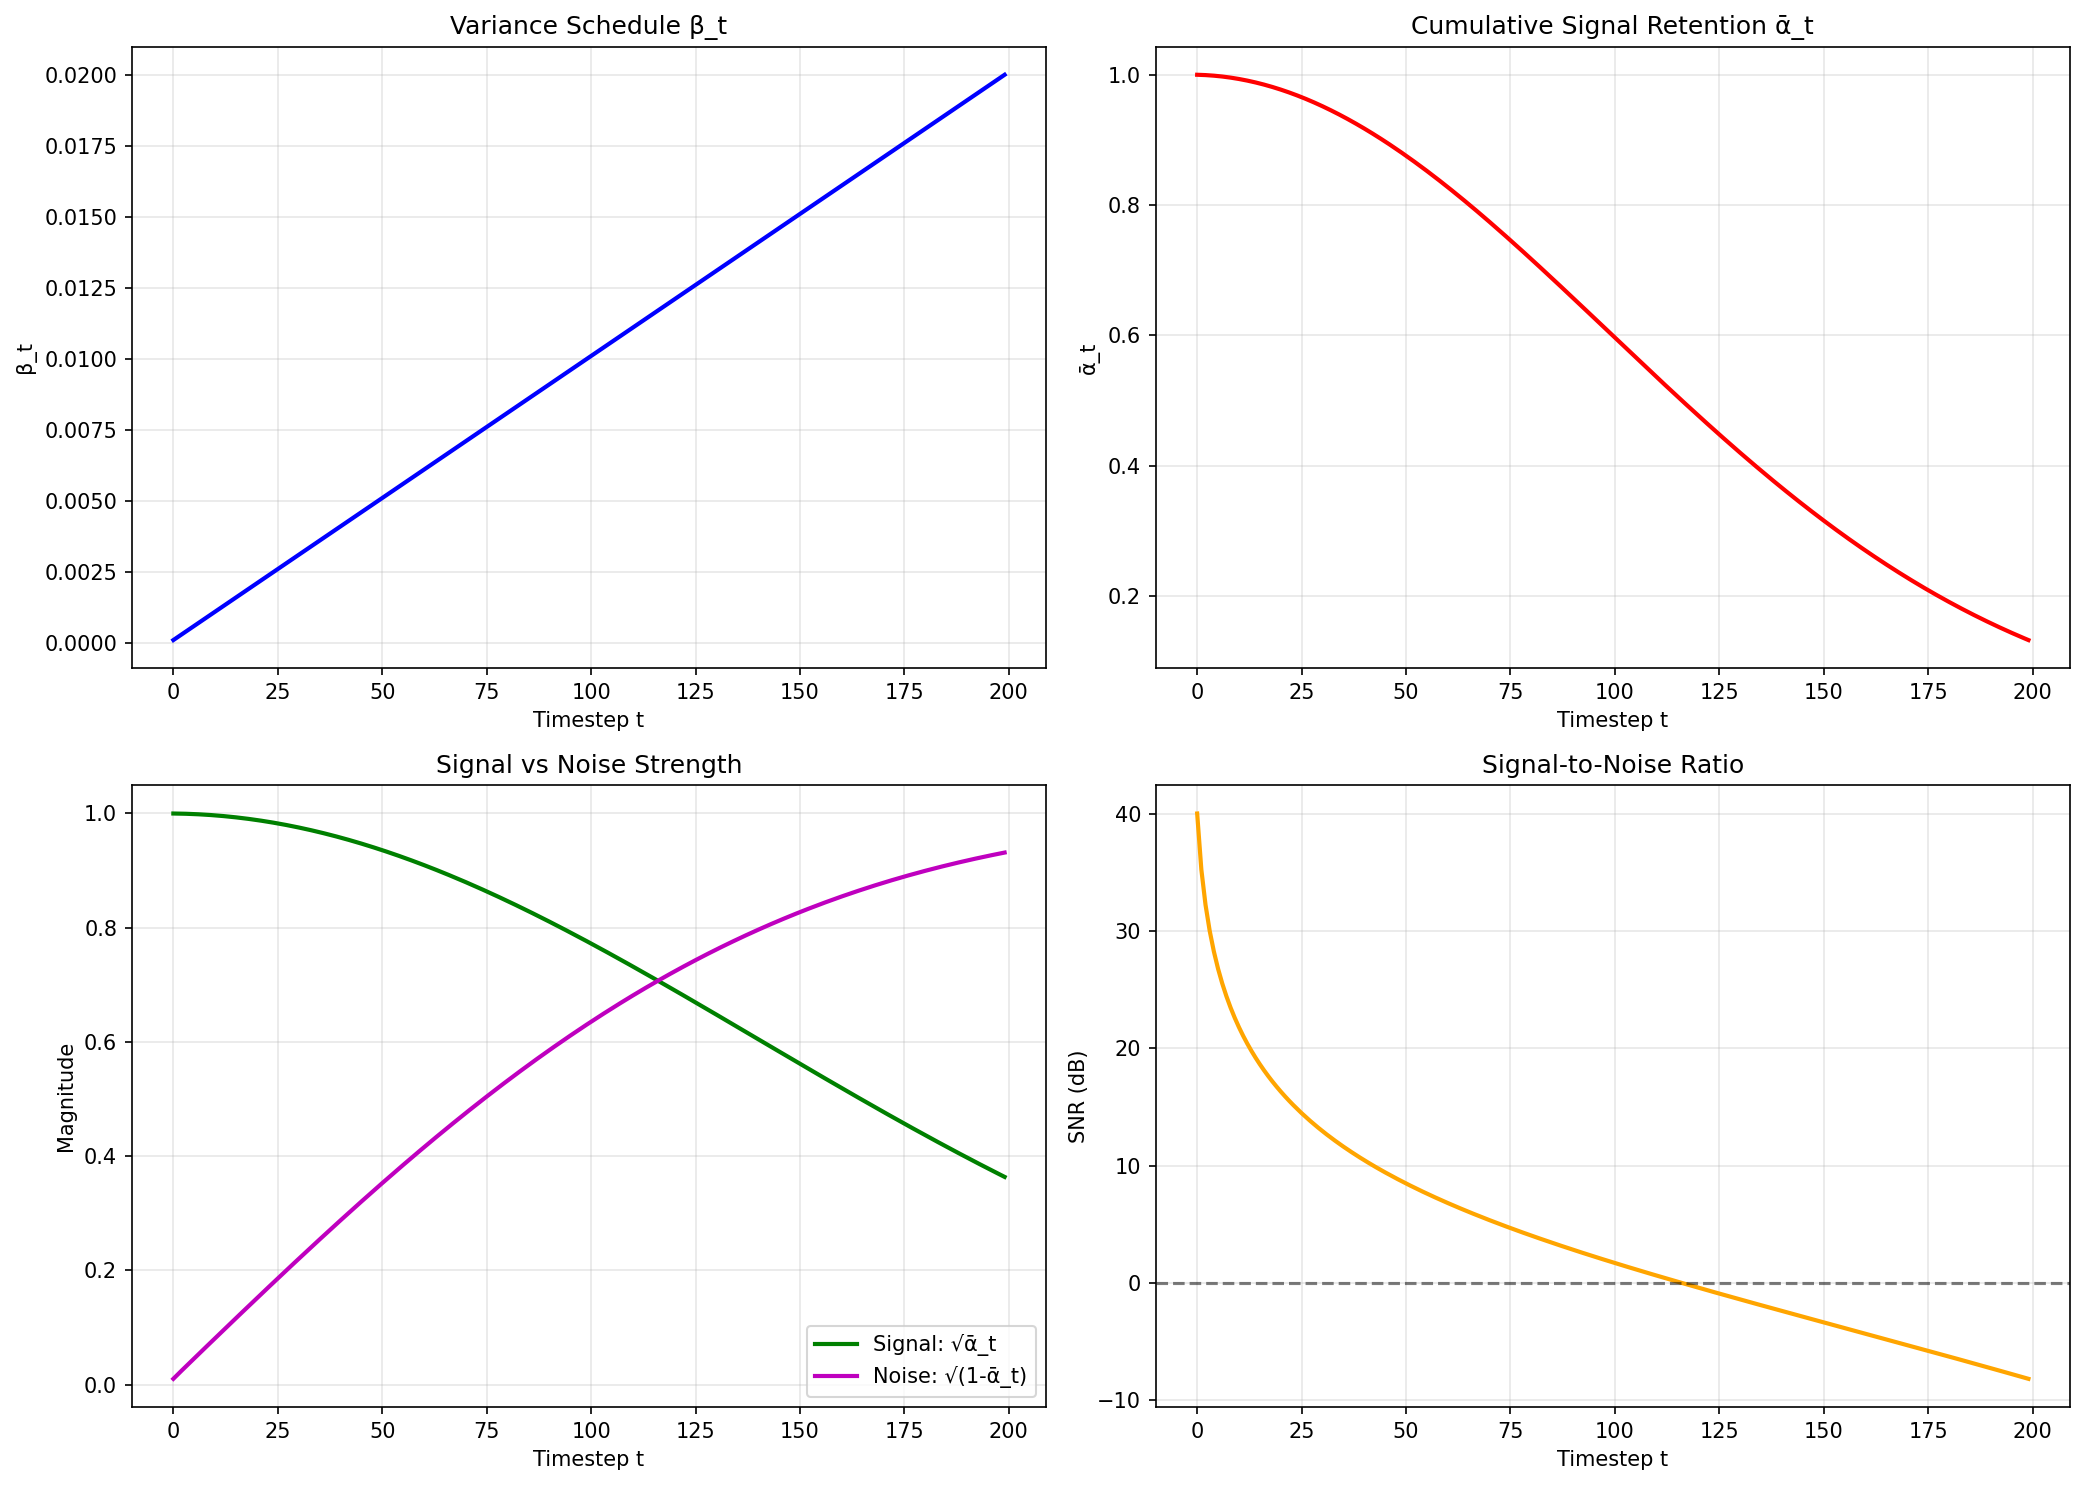

In [8]:
def create_diffusion_schedule(timesteps: int, 
                             beta_start: float = 1e-4,
                             beta_end: float = 0.02) -> dict:
    """
    Create linear variance schedule for diffusion process.
    
    Args:
        timesteps: Total number of diffusion steps T
        beta_start: Starting variance
        beta_end: Ending variance
        
    Returns:
        Dictionary containing:
        - betas: Variance schedule
        - alphas: 1 - betas
        - alphas_cumprod: Cumulative product of alphas
        - sqrt_alphas_cumprod: Square root of cumulative alphas
        - sqrt_one_minus_alphas_cumprod: Square root of (1 - cumulative alphas)
    """
    print(f"Creating diffusion schedule...")
    print(f"  Timesteps T = {timesteps}")
    print(f"  β_start = {beta_start}")
    print(f"  β_end = {beta_end}")
    
    # Linear schedule
    betas = torch.linspace(beta_start, beta_end, timesteps)
    
    # Compute derived quantities
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
    
    schedule = {
        'betas': betas,
        'alphas': alphas,
        'alphas_cumprod': alphas_cumprod,
        'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
        'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod
    }
    
    # Print key values at different timesteps
    print(f"\nSchedule analysis:")
    checkpoints = [0, timesteps//4, timesteps//2, 3*timesteps//4, timesteps-1]
    for t in checkpoints:
        print(f"\n  t = {t+1}:")
        print(f"    β_t = {betas[t]:.6f}")
        print(f"    α_t = {alphas[t]:.6f}")
        print(f"    ᾱ_t = {alphas_cumprod[t]:.6f}")
        print(f"    Signal strength: {sqrt_alphas_cumprod[t]:.4f}")
        print(f"    Noise strength: {sqrt_one_minus_alphas_cumprod[t]:.4f}")
        
        # Calculate SNR (Signal-to-Noise Ratio)
        snr = alphas_cumprod[t] / (1 - alphas_cumprod[t])
        print(f"    SNR: {snr:.4f} ({10*torch.log10(snr):.2f} dB)")
    
    return schedule

# Create schedule
timesteps = 200
schedule = create_diffusion_schedule(timesteps)

# Visualize schedule
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

t_range = np.arange(timesteps)

# Plot 1: Beta schedule
axes[0, 0].plot(t_range, schedule['betas'].numpy(), 'b-', linewidth=2)
axes[0, 0].set_xlabel('Timestep t')
axes[0, 0].set_ylabel('β_t')
axes[0, 0].set_title('Variance Schedule β_t')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Alpha cumulative product
axes[0, 1].plot(t_range, schedule['alphas_cumprod'].numpy(), 'r-', linewidth=2)
axes[0, 1].set_xlabel('Timestep t')
axes[0, 1].set_ylabel('ᾱ_t')
axes[0, 1].set_title('Cumulative Signal Retention ᾱ_t')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Signal and noise strength
axes[1, 0].plot(t_range, schedule['sqrt_alphas_cumprod'].numpy(), 'g-', 
                linewidth=2, label='Signal: √ᾱ_t')
axes[1, 0].plot(t_range, schedule['sqrt_one_minus_alphas_cumprod'].numpy(), 'm-',
                linewidth=2, label='Noise: √(1-ᾱ_t)')
axes[1, 0].set_xlabel('Timestep t')
axes[1, 0].set_ylabel('Magnitude')
axes[1, 0].set_title('Signal vs Noise Strength')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: SNR in dB
snr = schedule['alphas_cumprod'] / (1 - schedule['alphas_cumprod'])
snr_db = 10 * torch.log10(snr + 1e-10)
axes[1, 1].plot(t_range, snr_db.numpy(), 'orange', linewidth=2)
axes[1, 1].set_xlabel('Timestep t')
axes[1, 1].set_ylabel('SNR (dB)')
axes[1, 1].set_title('Signal-to-Noise Ratio')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('outputs_2/diffusion_schedule_analysis.png', dpi=150, bbox_inches='tight')
print(f"\n{'='*60}")
print(f"Schedule visualization saved")
print(f"{'='*60}")
plt.show()

## Cell 6: Forward Diffusion Process - Adding Noise

### Forward Process Mathematics

Given a clean structure $x_0$, we can sample a noisy version at any timestep $t$ directly:

$$x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon$$

where $\epsilon \sim \mathcal{N}(0, I)$ is standard Gaussian noise.

### Properties

1. **Reparameterization trick**: Enables backpropagation through sampling
2. **Deterministic given $\epsilon$**: Same noise $\epsilon$ gives same $x_t$
3. **Preserves domain**: If $x_0 \in [0, 1]^3$, most of $x_t$ stays near [0, 1]³
4. **Gradually destroys structure**: At $t = T$, $x_T \approx \mathcal{N}(0, I)$

### Visualization

We'll visualize how a crystal structure is progressively noised.

Demonstrating forward diffusion process...

Clean structure:
  Number of atoms: 2
  Position range: [0.000, 0.500]
  Position mean: 0.250
  Position std: 0.274
\nt = 0:
  Signal strength: 0.9999
  Noise strength: 0.0100
  Position range: [-0.016, 0.503]
  Position mean: 0.249
  Position std: 0.270
\nt = 50:
  Signal strength: 0.9357
  Noise strength: 0.3527
  Position range: [-0.912, 0.984]
  Position mean: 0.318
  Position std: 0.539
\nt = 100:
  Signal strength: 0.7723
  Noise strength: 0.6353
  Position range: [-1.465, 1.181]
  Position mean: 0.396
  Position std: 0.467
\nt = 150:
  Signal strength: 0.5617
  Noise strength: 0.8273
  Position range: [-1.105, 1.572]
  Position mean: 0.195
  Position std: 0.199
\nt = 199:
  Signal strength: 0.3636
  Noise strength: 0.9316
  Position range: [-1.326, 1.997]
  Position mean: 0.088
  Position std: 0.685
\n============================================================
Forward diffusion visualization saved


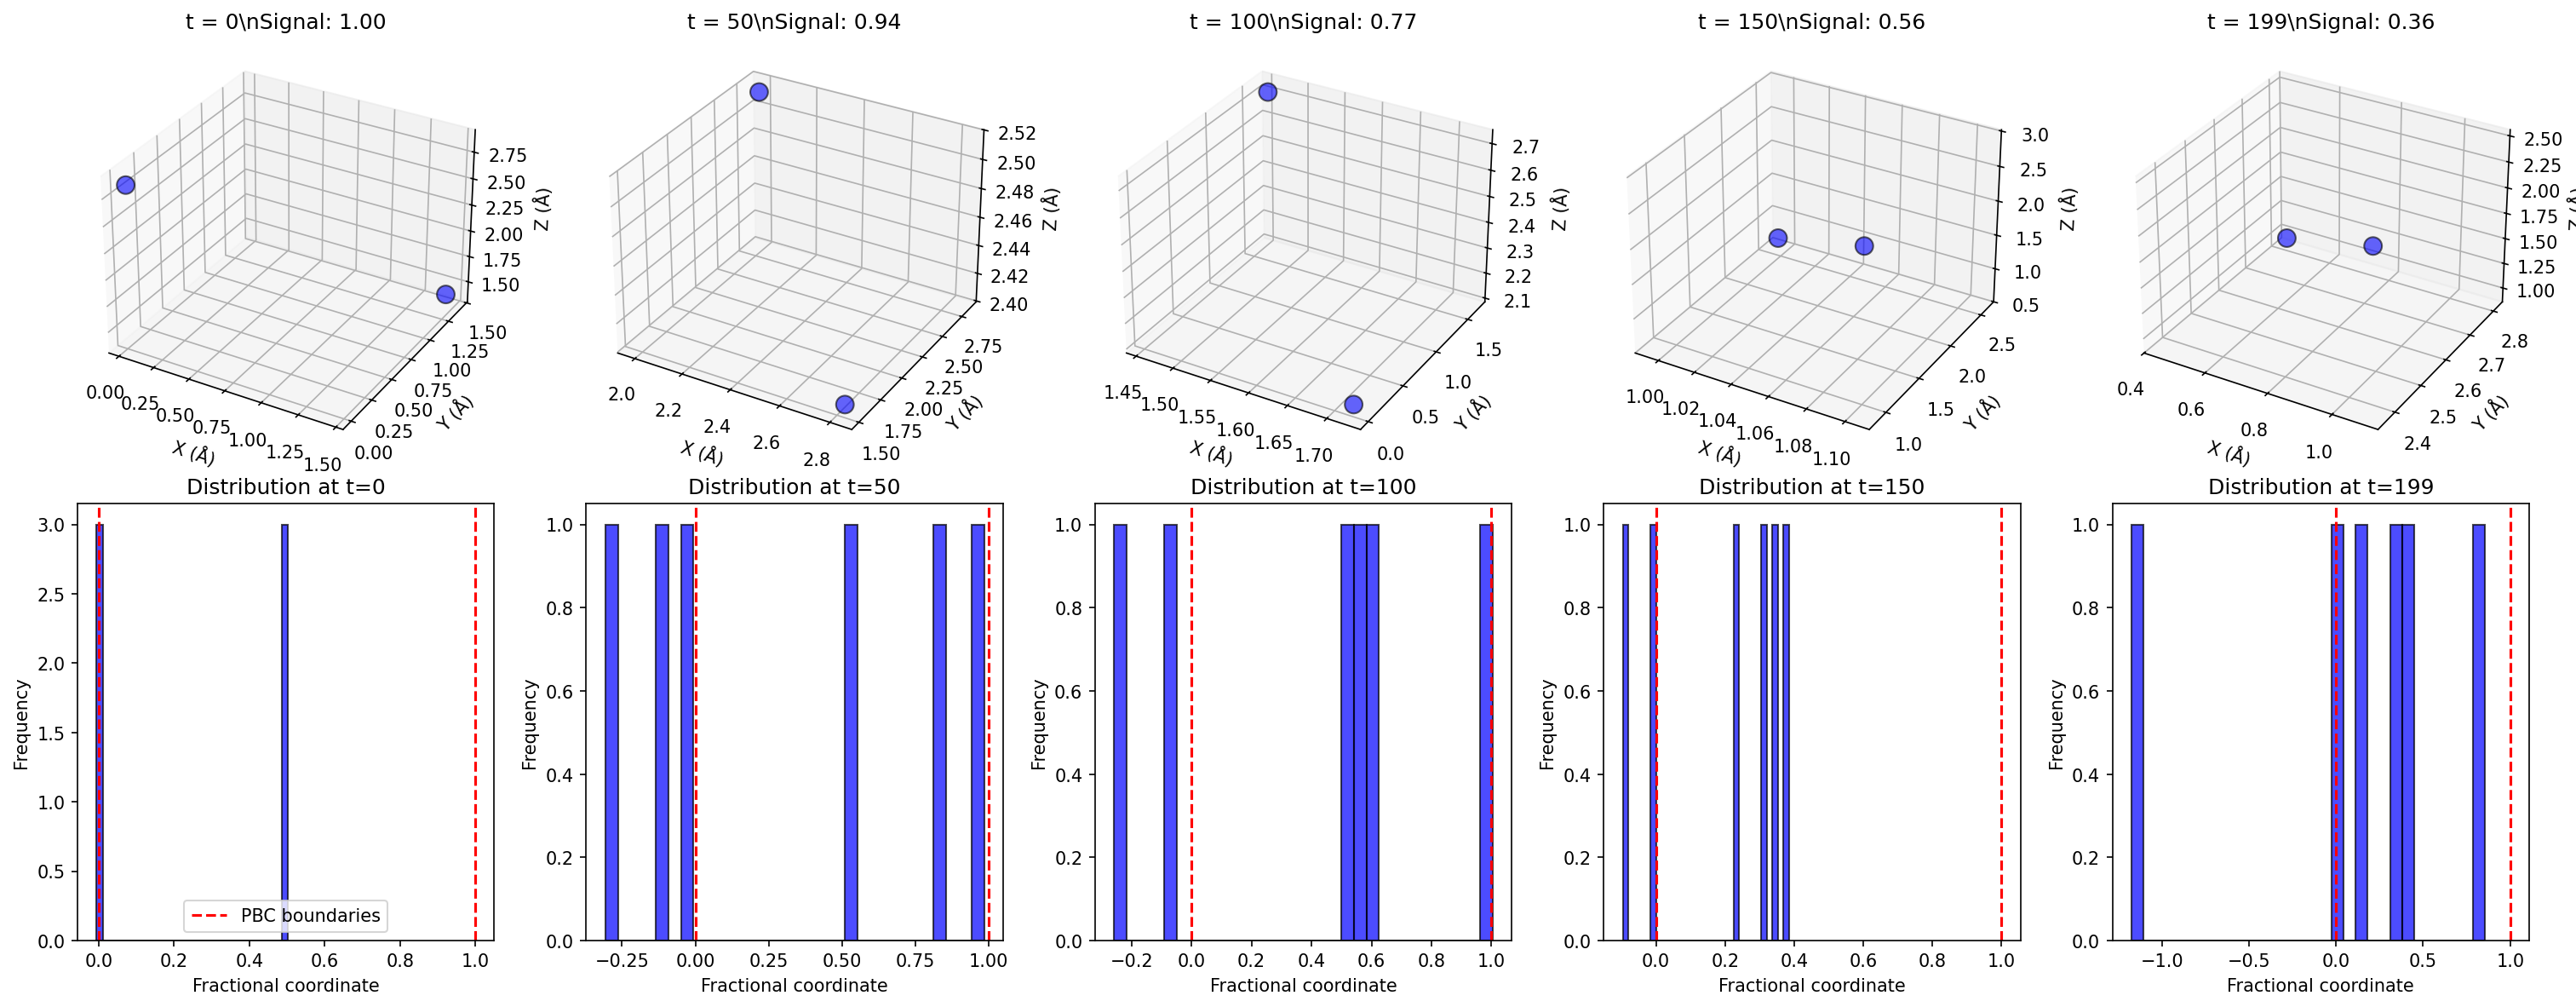

In [10]:
def forward_diffusion_sample(x_0: torch.Tensor, 
                            t: torch.Tensor, 
                            schedule: dict,
                            noise: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Sample from q(x_t | x_0) - the forward diffusion process.
    
    Mathematical formula:
        x_t = √(ᾱ_t) * x_0 + √(1-ᾱ_t) * ε
    
    Args:
        x_0: Clean data (batch, max_atoms, 3)
        t: Timestep (batch,) - values in [0, T-1]
        schedule: Dictionary with diffusion parameters
        noise: Optional pre-generated noise
        
    Returns:
        x_t: Noised data at timestep t
        noise: The noise that was added
    """
    # Generate noise if not provided
    if noise is None:
        noise = torch.randn_like(x_0)
    
    # Extract coefficients for timestep t
    # Shape: (batch, 1, 1) for broadcasting
    sqrt_alpha_t = schedule['sqrt_alphas_cumprod'][t][:, None, None]
    sqrt_one_minus_alpha_t = schedule['sqrt_one_minus_alphas_cumprod'][t][:, None, None]
    
    # Apply forward diffusion formula
    x_t = sqrt_alpha_t * x_0 + sqrt_one_minus_alpha_t * noise
    
    return x_t, noise

# Demonstrate forward diffusion
print("Demonstrating forward diffusion process...\n")

# Get a clean crystal structure
x_0 = sample_batch['positions'][:1]  # Take first sample
mask = sample_batch['mask'][:1]
lattice = sample_batch['lattice'][:1]

n_real_atoms = int(mask.sum().item())
print(f"Clean structure:")
print(f"  Number of atoms: {n_real_atoms}")
print(f"  Position range: [{x_0.min():.3f}, {x_0.max():.3f}]")
print(f"  Position mean: {x_0[mask>0.5].mean():.3f}")
print(f"  Position std: {x_0[mask>0.5].std():.3f}")

# Sample at different timesteps
timesteps_to_visualize = [0, 50, 100, 150, 199]

# Visualize at different timesteps
fig = plt.figure(figsize=(20, 8))

for idx, t_val in enumerate(timesteps_to_visualize):
    # Create timestep tensor
    t = torch.tensor([t_val])
    
    # Apply forward diffusion
    x_t, noise = forward_diffusion_sample(x_0, t, schedule)
    
    # Enforce PBC
    x_t_pbc = x_t % 1.0
    
    # Calculate statistics
    signal_strength = schedule['sqrt_alphas_cumprod'][t_val].item()
    noise_strength = schedule['sqrt_one_minus_alphas_cumprod'][t_val].item()
    
    print(f"\\nt = {t_val}:")
    print(f"  Signal strength: {signal_strength:.4f}")
    print(f"  Noise strength: {noise_strength:.4f}")
    print(f"  Position range: [{x_t.min():.3f}, {x_t.max():.3f}]")
    print(f"  Position mean: {x_t[mask>0.5].mean():.3f}")
    print(f"  Position std: {x_t[mask>0.5].std():.3f}")
    
    # Plot 3D structure - CREATE SUBPLOT CORRECTLY
    ax = fig.add_subplot(2, len(timesteps_to_visualize), idx+1, projection='3d')
    
    # Extract real atoms
    pos_real = x_t_pbc[0][mask[0] > 0.5].numpy()
    
    # Convert to Cartesian
    cart_pos = pos_real @ lattice[0].numpy()
    
    ax.scatter(cart_pos[:, 0], cart_pos[:, 1], cart_pos[:, 2],
               c='blue', s=100, alpha=0.6, edgecolors='black')
    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    ax.set_title(f't = {t_val}\\nSignal: {signal_strength:.2f}')
    
    # Plot distribution of positions
    ax2 = fig.add_subplot(2, len(timesteps_to_visualize), len(timesteps_to_visualize) + idx + 1)
    ax2.hist(x_t[mask>0.5].flatten().numpy(), bins=30, alpha=0.7, color='blue', edgecolor='black')
    ax2.axvline(0, color='red', linestyle='--', label='PBC boundaries')
    ax2.axvline(1, color='red', linestyle='--')
    ax2.set_xlabel('Fractional coordinate')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'Distribution at t={t_val}')
    if idx == 0:
        ax2.legend()

plt.tight_layout()
plt.savefig('outputs_2/forward_diffusion_process.png', dpi=150, bbox_inches='tight')
print(f"\\n{'='*60}")
print(f"Forward diffusion visualization saved")
print(f"{'='*60}")
plt.show()

## Cell 7: Neural Network Architecture - U-Net with Self-Attention

### U-Net Architecture for Point Clouds

The neural network $\epsilon_\theta(x_t, t)$ must:
1. Take noisy positions $x_t \in \mathbb{R}^{N \times 3}$ as input
2. Take timestep $t \in [0, T]$ as conditioning
3. Output predicted noise $\hat{\epsilon} \in \mathbb{R}^{N \times 3}$

### Architecture Components

1. **Sinusoidal Position Embeddings** (Vaswani et al., 2017):
   $$PE_{(t, 2i)} = \sin(t / 10000^{2i/d})$$
   $$PE_{(t, 2i+1)} = \cos(t / 10000^{2i/d})$$

2. **Multi-Layer Perceptron (MLP)**:
   $$h = \text{GELU}(W_2 \cdot \text{GELU}(W_1 \cdot [x_t, t_{emb}] + b_1) + b_2)$$

3. **Self-Attention** (optional, for capturing global interactions):
   $$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

4. **Residual Connections**:
   $$x_{out} = x_{in} + F(x_{in})$$

### Complexity Analysis

- **Time per forward pass**: $O(N \times d^2)$ where $N$ = atoms, $d$ = hidden dimension
- **Space**: $O(N \times d)$
- **With self-attention**: $O(N^2 \times d)$ time

In [11]:
class SinusoidalPositionEmbeddings(nn.Module):
    """
    Sinusoidal embeddings for timestep conditioning.
    
    Following 'Attention is All You Need' (Vaswani et al., 2017)
    """
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim
        
    def forward(self, time: torch.Tensor) -> torch.Tensor:
        """
        Args:
            time: (batch,) timestep values
            
        Returns:
            embeddings: (batch, dim) sinusoidal embeddings
        """
        device = time.device
        half_dim = self.dim // 2
        
        # Calculate embeddings
        embeddings = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
        
        return embeddings


class CrystalDenoisingNetwork(nn.Module):
    """
    Neural network for predicting noise in crystal structures.
    
    Architecture:
    1. Sinusoidal time embeddings
    2. MLP encoder: positions + time -> hidden features
    3. Residual blocks with activation
    4. MLP decoder: hidden features -> noise prediction
    
    Input: (batch, max_atoms, 3) positions + (batch,) timesteps
    Output: (batch, max_atoms, 3) predicted noise
    """
    
    def __init__(self, hidden_dim: int = 128, time_embed_dim: int = 128, num_layers: int = 4):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.time_embed_dim = time_embed_dim
        self.num_layers = num_layers
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_embed_dim),
            nn.Linear(time_embed_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Encoder: positions (3D) -> hidden
        self.encoder = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Middle layers (residual blocks)
        self.middle_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.GELU(),
                nn.Linear(hidden_dim, hidden_dim)
            ) for _ in range(num_layers)
        ])
        
        # Decoder: hidden -> noise (3D)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 3)
        )
        
        print(f"\nCrystalDenoisingNetwork initialized:")
        print(f"  Hidden dimension: {hidden_dim}")
        print(f"  Time embedding dimension: {time_embed_dim}")
        print(f"  Number of layers: {num_layers}")
        
        # Count parameters
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"  Total parameters: {total_params:,}")
        print(f"  Trainable parameters: {trainable_params:,}")
        
    def forward(self, x: torch.Tensor, t: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the denoising network.
        
        Args:
            x: (batch, max_atoms, 3) noisy positions
            t: (batch,) timesteps
            mask: (batch, max_atoms) binary mask
            
        Returns:
            noise_pred: (batch, max_atoms, 3) predicted noise
        """
        # Embed time
        t_emb = self.time_mlp(t)  # (batch, hidden_dim)
        t_emb = t_emb[:, None, :]  # (batch, 1, hidden_dim) for broadcasting
        
        # Encode positions
        h = self.encoder(x)  # (batch, max_atoms, hidden_dim)
        
        # Add time embedding
        h = h + t_emb
        
        # Apply middle layers with residual connections
        for layer in self.middle_layers:
            h = h + layer(h)  # Residual connection
        
        # Decode to noise prediction
        noise_pred = self.decoder(h)  # (batch, max_atoms, 3)
        
        # Apply mask to zero out predictions for padding
        noise_pred = noise_pred * mask[:, :, None]
        
        return noise_pred

# Initialize network
network = CrystalDenoisingNetwork(
    hidden_dim=128,
    time_embed_dim=128,
    num_layers=4
).to(device)

# Test forward pass
print("\nTesting forward pass...")
with torch.no_grad():
    test_x = sample_batch['positions'][:2].to(device)
    test_t = torch.tensor([50, 100]).to(device)
    test_mask = sample_batch['mask'][:2].to(device)
    
    print(f"\nInput shapes:")
    print(f"  x: {test_x.shape}")
    print(f"  t: {test_t.shape}")
    print(f"  mask: {test_mask.shape}")
    
    output = network(test_x, test_t, test_mask)
    
    print(f"\nOutput shape: {output.shape}")
    print(f"Output range: [{output.min():.3f}, {output.max():.3f}]")
    print(f"Output mean: {output.mean():.6f}")
    print(f"Output std: {output.std():.6f}")

print(f"\n{'='*60}")
print(f"Network architecture test successful!")
print(f"{'='*60}")


CrystalDenoisingNetwork initialized:
  Hidden dimension: 128
  Time embedding dimension: 128
  Number of layers: 4
  Total parameters: 199,043
  Trainable parameters: 199,043

Testing forward pass...

Input shapes:
  x: torch.Size([2, 8, 3])
  t: torch.Size([2])
  mask: torch.Size([2, 8])

Output shape: torch.Size([2, 8, 3])
Output range: [-0.101, 0.073]
Output mean: -0.000289
Output std: 0.029267

Network architecture test successful!


## Cell 8: Complete Diffusion Model Class

### Integrating All Components

The `CrystalDiffusionModel` class combines:
1. **Diffusion schedule**: Noise variance parameters
2. **Neural network**: Noise prediction model
3. **Physics validator**: Structure correction
4. **Training logic**: Loss computation and optimization
5. **Sampling logic**: Reverse diffusion process

### Loss Function (Simplified DDPM)

$$L_{\text{simple}} = \mathbb{E}_{t, x_0, \epsilon}[\|\epsilon - \epsilon_\theta(\sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon, t)\|^2]$$

This is the Mean Squared Error (MSE) between:
- True noise $\epsilon$ added to the structure
- Predicted noise $\epsilon_\theta(x_t, t)$ from the network

### Algorithm - Training Step

```
For each training iteration:
  1. Sample batch of clean structures x_0
  2. Sample random timesteps t ~ Uniform(0, T)
  3. Sample noise ε ~ N(0, I)
  4. Compute noisy structures: x_t = √(ᾱ_t)·x_0 + √(1-ᾱ_t)·ε
  5. Predict noise: ε_pred = ε_θ(x_t, t)
  6. Compute loss: L = ||ε - ε_pred||²
  7. Backpropagate and update parameters
```

In [12]:
class CrystalDiffusionModel:
    """
    Complete diffusion model for crystal structure generation.
    
    Combines:
    - Diffusion schedule (forward and reverse)
    - Denoising neural network
    - Physics validation and correction
    - Training and sampling algorithms
    """
    
    def __init__(self, timesteps: int = 200, device: str = 'cpu'):
        self.timesteps = timesteps
        self.device = device
        
        print(f"\nInitializing CrystalDiffusionModel...")
        print(f"  Timesteps: {timesteps}")
        print(f"  Device: {device}")
        
        # Create diffusion schedule
        self.schedule = create_diffusion_schedule(timesteps)
        
        # Move schedule to device
        for key in self.schedule:
            self.schedule[key] = self.schedule[key].to(device)
        
        # Initialize neural network
        self.model = CrystalDenoisingNetwork(
            hidden_dim=128,
            time_embed_dim=128,
            num_layers=4
        ).to(device)
        
        # Initialize physics validator
        self.validator = PhysicsValidator(min_distance=0.7)
        
        # Initialize optimizer
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=1e-4,
            weight_decay=1e-4
        )
        
        print(f"\nModel initialization complete!")
    
    def compute_loss(self, batch: dict) -> torch.Tensor:
        """
        Compute DDPM loss for a batch.
        
        Algorithm:
        1. Extract clean positions x_0
        2. Sample random timesteps t
        3. Sample noise ε
        4. Create noisy positions x_t
        5. Predict noise ε_pred
        6. Compute MSE loss
        
        Args:
            batch: Dictionary with 'positions', 'mask', 'lattice'
            
        Returns:
            loss: Scalar loss value
        """
        # Move batch to device
        x_0 = batch['positions'].to(self.device)
        mask = batch['mask'].to(self.device)
        
        batch_size = x_0.shape[0]
        
        # 1. Sample random timesteps for each sample in batch
        t = torch.randint(0, self.timesteps, (batch_size,), device=self.device)
        
        # 2. Sample noise
        noise = torch.randn_like(x_0)
        
        # 3. Apply forward diffusion
        x_t, _ = forward_diffusion_sample(x_0, t, self.schedule, noise)
        
        # 4. Predict noise
        noise_pred = self.model(x_t, t, mask)
        
        # 5. Compute loss (MSE between true and predicted noise)
        # Only compute loss for real atoms (using mask)
        loss = F.mse_loss(
            noise_pred * mask[:, :, None],
            noise * mask[:, :, None],
            reduction='mean'
        )
        
        return loss
    
    def train_step(self, batch: dict) -> float:
        """
        Perform one training step.
        
        Returns:
            loss: Loss value for this batch
        """
        self.model.train()
        
        # Compute loss
        loss = self.compute_loss(batch)
        
        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping (prevents exploding gradients)
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        
        # Update parameters
        self.optimizer.step()
        
        return loss.item()
    
    @torch.no_grad()
    def sample(self, batch_size: int, max_atoms: int, 
               lattice: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """
        Generate new crystal structures using reverse diffusion.
        
        Algorithm (DDPM Sampling):
        1. Start with random noise x_T ~ N(0, I)
        2. For t = T-1, ..., 0:
            a. Predict noise: ε_θ(x_t, t)
            b. Compute mean: μ = (x_t - ε_θ·√(1-ᾱ_t)) / √ᾱ_t
            c. Add noise: x_{t-1} = μ + σ_t·z where z ~ N(0, I)
        3. Return x_0
        
        Args:
            batch_size: Number of structures to generate
            max_atoms: Maximum number of atoms
            lattice: Lattice vectors (batch, 3, 3)
            mask: Binary mask (batch, max_atoms)
            
        Returns:
            x_0: Generated structures (batch, max_atoms, 3)
        """
        self.model.eval()
        
        print(f"\nGenerating {batch_size} structures...")
        print(f"  Max atoms: {max_atoms}")
        print(f"  Timesteps: {self.timesteps}")
        
        # Start with pure noise
        x = torch.randn(batch_size, max_atoms, 3, device=self.device)
        
        # Reverse diffusion process
        for t_idx in reversed(range(self.timesteps)):
            t = torch.full((batch_size,), t_idx, device=self.device, dtype=torch.long)
            
            # Predict noise
            predicted_noise = self.model(x, t, mask)
            
            # Get schedule parameters
            alpha_t = self.schedule['alphas'][t_idx]
            alpha_bar_t = self.schedule['alphas_cumprod'][t_idx]
            beta_t = self.schedule['betas'][t_idx]
            
            # Compute mean of p(x_{t-1} | x_t)
            # Formula: μ = (1/√α_t) * (x_t - (β_t/√(1-ᾱ_t)) * ε_θ)
            coef1 = 1.0 / torch.sqrt(alpha_t)
            coef2 = beta_t / torch.sqrt(1.0 - alpha_bar_t)
            mean = coef1 * (x - coef2 * predicted_noise)
            
            if t_idx > 0:
                # Add noise for stochasticity (except at final step)
                noise = torch.randn_like(x)
                sigma_t = torch.sqrt(beta_t)
                x = mean + sigma_t * noise
            else:
                x = mean
            
            # Enforce periodic boundary conditions
            x = self.validator.enforce_pbc(x)
            
            # Progress indicator
            if (self.timesteps - t_idx) % 50 == 0:
                print(f"  Step {self.timesteps - t_idx}/{self.timesteps}")
        
        print(f"  Generation complete!")
        
        return x

# Initialize complete model
model = CrystalDiffusionModel(timesteps=200, device=device)

print(f"\n{'='*60}")
print(f"Complete diffusion model initialized and ready for training!")
print(f"{'='*60}")


Initializing CrystalDiffusionModel...
  Timesteps: 200
  Device: cuda
Creating diffusion schedule...
  Timesteps T = 200
  β_start = 0.0001
  β_end = 0.02

Schedule analysis:

  t = 1:
    β_t = 0.000100
    α_t = 0.999900
    ᾱ_t = 0.999900
    Signal strength: 0.9999
    Noise strength: 0.0100
    SNR: 9997.3408 (40.00 dB)

  t = 51:
    β_t = 0.005100
    α_t = 0.994900
    ᾱ_t = 0.875616
    Signal strength: 0.9357
    Noise strength: 0.3527
    SNR: 7.0396 (8.48 dB)

  t = 101:
    β_t = 0.010100
    α_t = 0.989900
    ᾱ_t = 0.596395
    Signal strength: 0.7723
    Noise strength: 0.6353
    SNR: 1.4777 (1.70 dB)

  t = 151:
    β_t = 0.015100
    α_t = 0.984900
    ᾱ_t = 0.315550
    Signal strength: 0.5617
    Noise strength: 0.8273
    SNR: 0.4610 (-3.36 dB)

  t = 200:
    β_t = 0.020000
    α_t = 0.980000
    ᾱ_t = 0.132183
    Signal strength: 0.3636
    Noise strength: 0.9316
    SNR: 0.1523 (-8.17 dB)

CrystalDenoisingNetwork initialized:
  Hidden dimension: 128
  Time em

## Cell 9: Training Loop with Detailed Monitoring

### Training Dynamics

During training, we monitor:
1. **Loss trajectory**: Should decrease and stabilize
2. **Gradient norms**: Should be stable (not exploding/vanishing)
3. **Learning rate**: Can use schedulers for adaptation
4. **Noise prediction quality**: Measured by MSE

### Expected Behavior

- **Initial loss**: High (~1.0 to 10.0) - random predictions
- **Middle training**: Steady decrease
- **Convergence**: Loss plateaus at ~0.01 to 0.1

### Optimization Considerations

1. **Adam/AdamW**: Adaptive learning rate, momentum
2. **Weight decay**: L2 regularization prevents overfitting
3. **Gradient clipping**: Prevents instability
4. **Batch size**: Larger = more stable but slower

Training Configuration:
{
  "epochs": 50,
  "batch_size": 4,
  "log_interval": 10
}

Starting Training...

Epoch  10/50  |  Loss: 0.091653  |  Min: 0.060499  |  Max: 0.122807
Epoch  20/50  |  Loss: 0.129619  |  Min: 0.066354  |  Max: 0.192883
Epoch  30/50  |  Loss: 0.081179  |  Min: 0.036270  |  Max: 0.126087
Epoch  40/50  |  Loss: 0.213770  |  Min: 0.052122  |  Max: 0.375418
Epoch  50/50  |  Loss: 0.058210  |  Min: 0.029842  |  Max: 0.086578

Training Complete!

Final Statistics:
  Final loss: 0.058210
  Best loss: 0.030757
  Loss reduction: 69.5%

Training curves saved to 'training_curve.png'


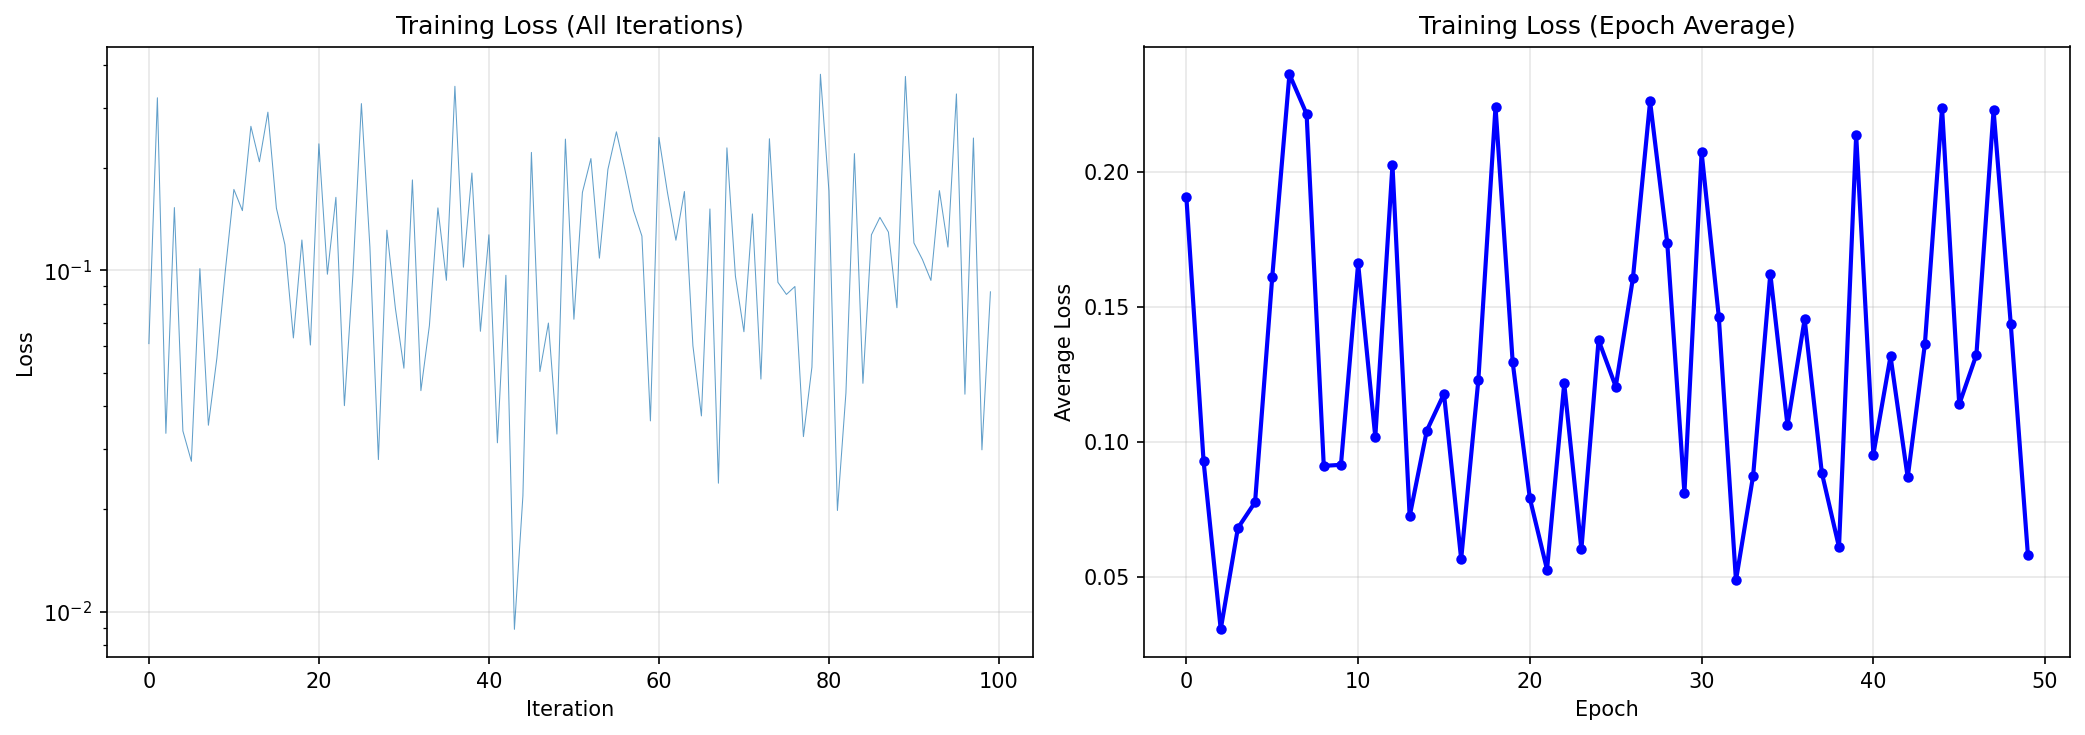

In [15]:
# Training configuration
config = {
    'epochs': 50,
    'batch_size': 4,
    'log_interval': 10
}

print(f"Training Configuration:")
print(json.dumps(config, indent=2))
print(f"\n{'='*60}")
print(f"Starting Training...")
print(f"{'='*60}\n")

# Training loop
losses = []
epoch_losses = []

for epoch in range(config['epochs']):
    epoch_loss_values = []
    
    for batch_idx, batch in enumerate(dataloader):
        # Perform training step
        loss = model.train_step(batch)
        epoch_loss_values.append(loss)
        losses.append(loss)
    
    # Calculate epoch statistics
    avg_epoch_loss = np.mean(epoch_loss_values)
    epoch_losses.append(avg_epoch_loss)
    
    # Logging
    if (epoch + 1) % config['log_interval'] == 0:
        print(f"Epoch {epoch+1:3d}/{config['epochs']}  |  "
              f"Loss: {avg_epoch_loss:.6f}  |  "
              f"Min: {min(epoch_loss_values):.6f}  |  "
              f"Max: {max(epoch_loss_values):.6f}")

print(f"\n{'='*60}")
print(f"Training Complete!")
print(f"{'='*60}")
print(f"\nFinal Statistics:")
print(f"  Final loss: {epoch_losses[-1]:.6f}")
print(f"  Best loss: {min(epoch_losses):.6f}")
print(f"  Loss reduction: {(epoch_losses[0] - epoch_losses[-1]) / epoch_losses[0] * 100:.1f}%")

# Visualize training
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss over all iterations
axes[0].plot(losses, alpha=0.7, linewidth=0.5)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss (All Iterations)')
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Plot 2: Epoch-averaged loss
axes[1].plot(epoch_losses, 'b-', linewidth=2, marker='o', markersize=4)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Average Loss')
axes[1].set_title('Training Loss (Epoch Average)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs_2/training_curve.png', dpi=150, bbox_inches='tight')
print(f"\nTraining curves saved to 'training_curve.png'")
plt.show()

## Cell 10: Reverse Diffusion - Step-by-Step Visualization

### Reverse Process Mathematics

Starting from pure noise $x_T \sim \mathcal{N}(0, I)$, we iteratively denoise:

$$p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \sigma_t^2 I)$$

Where:
$$\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta(x_t, t)\right)$$

$$\sigma_t = \sqrt{\beta_t}$$

### Denoising Process

At each step:
1. **Predict noise**: $\hat{\epsilon} = \epsilon_\theta(x_t, t)$
2. **Compute clean signal**: $\hat{x}_0 = \frac{x_t - \sqrt{1-\bar{\alpha}_t}\hat{\epsilon}}{\sqrt{\bar{\alpha}_t}}$
3. **Sample**: $x_{t-1} \sim \mathcal{N}(\mu_\theta, \sigma_t^2 I)$

We'll visualize the denoising process at key timesteps.

Generating structure with detailed visualization...

Reverse diffusion process:
  Total timesteps: 200
  Visualizing at: [199, 150, 100, 50, 0]

  t = 199:
    Position range: [0.019, 0.982]
    Position mean: 0.633
    Position std: 0.383
    Noise pred norm: 3.436
  t = 150:
    Position range: [0.097, 0.989]
    Position mean: 0.601
    Position std: 0.323
    Noise pred norm: 1.145
  t = 100:
    Position range: [0.442, 0.557]
    Position mean: 0.496
    Position std: 0.045
    Noise pred norm: 0.731
  t =  50:
    Position range: [0.005, 0.834]
    Position mean: 0.607
    Position std: 0.323
    Noise pred norm: 1.297
  t =   0:
    Position range: [0.137, 0.676]
    Position mean: 0.416
    Position std: 0.231
    Noise pred norm: 0.466
\nReverse diffusion visualization saved


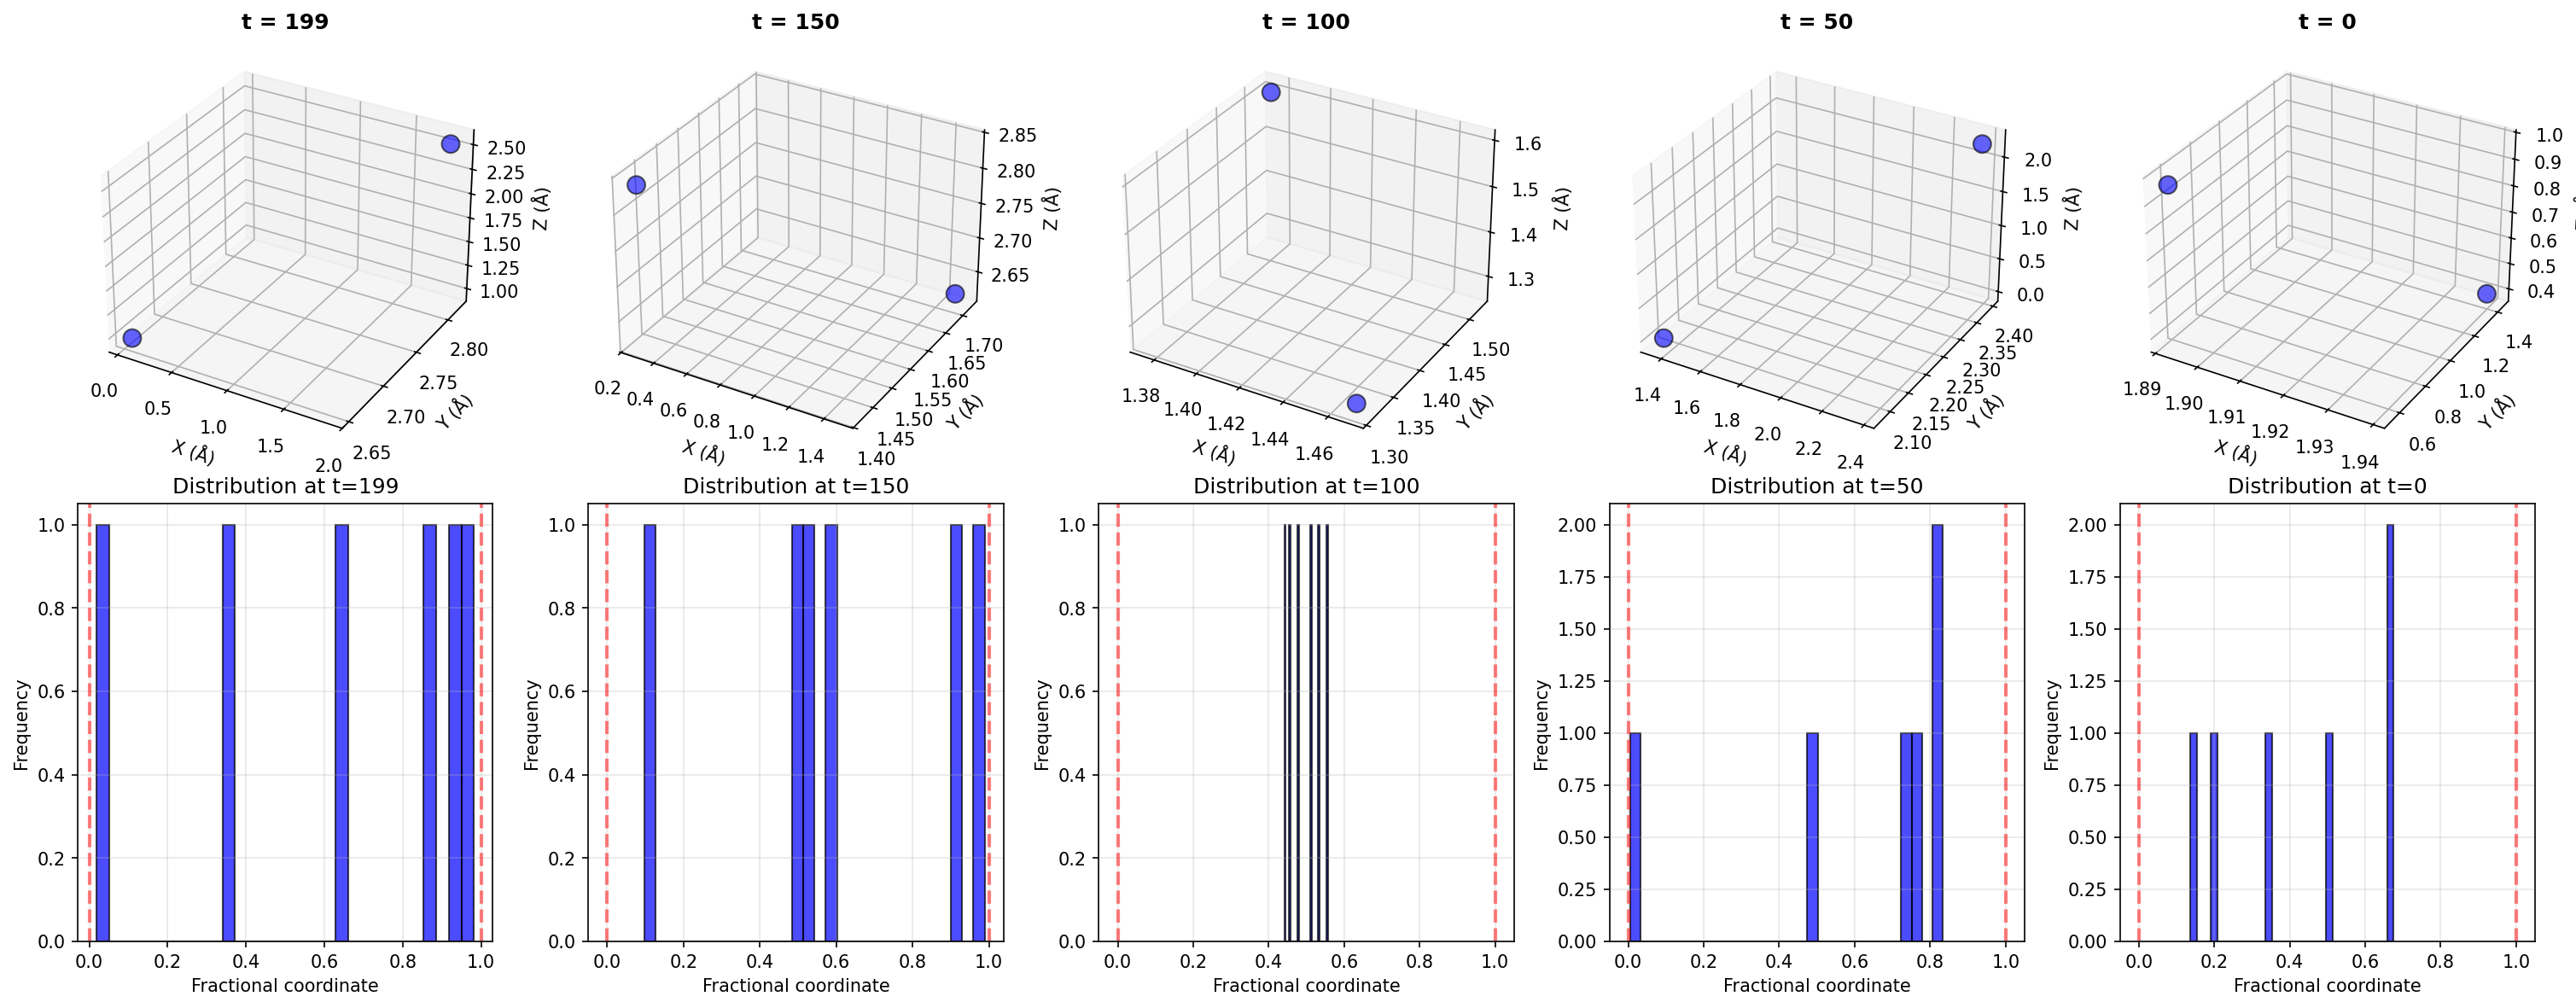

In [16]:
# Generate a new structure with visualization
print(f"Generating structure with detailed visualization...\n")

# Use lattice and mask from dataset
sample_batch = next(iter(dataloader))
gen_lattice = sample_batch['lattice'][:1].to(device)
gen_mask = sample_batch['mask'][:1].to(device)
max_atoms = dataset.max_atoms

# Manual sampling with visualization at key steps
model.model.eval()

# Start with pure noise
x = torch.randn(1, max_atoms, 3, device=device)

# Timesteps to visualize
vis_timesteps = [199, 150, 100, 50, 0]
vis_structures = []

print(f"Reverse diffusion process:")
print(f"  Total timesteps: {model.timesteps}")
print(f"  Visualizing at: {vis_timesteps}\n")

with torch.no_grad():
    for t_idx in reversed(range(model.timesteps)):
        t = torch.full((1,), t_idx, device=device, dtype=torch.long)
        
        # Predict noise
        predicted_noise = model.model(x, t, gen_mask)
        
        # Get schedule parameters
        alpha_t = model.schedule['alphas'][t_idx]
        alpha_bar_t = model.schedule['alphas_cumprod'][t_idx]
        beta_t = model.schedule['betas'][t_idx]
        
        # Compute mean
        coef1 = 1.0 / torch.sqrt(alpha_t)
        coef2 = beta_t / torch.sqrt(1.0 - alpha_bar_t)
        mean = coef1 * (x - coef2 * predicted_noise)
        
        if t_idx > 0:
            noise = torch.randn_like(x)
            sigma_t = torch.sqrt(beta_t)
            x = mean + sigma_t * noise
        else:
            x = mean
        
        # Enforce PBC
        x = model.validator.enforce_pbc(x)
        
        # Save for visualization
        if t_idx in vis_timesteps:
            vis_structures.append((t_idx, x.clone().cpu()))
            
            # Calculate statistics
            x_real = x[0][gen_mask[0] > 0.5]
            print(f"  t = {t_idx:3d}:")
            print(f"    Position range: [{x_real.min():.3f}, {x_real.max():.3f}]")
            print(f"    Position mean: {x_real.mean():.3f}")
            print(f"    Position std: {x_real.std():.3f}")
            print(f"    Noise pred norm: {predicted_noise.norm():.3f}")

# Visualize denoising process
fig = plt.figure(figsize=(20, 8))

for idx, (t_val, structure) in enumerate(vis_structures):
    # 3D structure - CREATE PROPERLY
    ax = fig.add_subplot(2, len(vis_structures), idx+1, projection='3d')
    
    # Extract real atoms
    pos = structure[0][gen_mask[0].cpu() > 0.5].numpy()
    
    # Convert to Cartesian
    cart_pos = pos @ gen_lattice[0].cpu().numpy()
    
    # Plot
    ax.scatter(cart_pos[:, 0], cart_pos[:, 1], cart_pos[:, 2],
               c='blue', s=100, alpha=0.6, edgecolors='black')
    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    ax.set_title(f't = {t_val}', fontweight='bold')
    
    # Distribution
    ax2 = fig.add_subplot(2, len(vis_structures), len(vis_structures) + idx + 1)
    ax2.hist(pos.flatten(), bins=30, alpha=0.7, color='blue', edgecolor='black')
    ax2.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.5)
    ax2.axvline(1, color='red', linestyle='--', linewidth=2, alpha=0.5)
    ax2.set_xlabel('Fractional coordinate')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'Distribution at t={t_val}')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs_2/reverse_diffusion_process.png', dpi=150, bbox_inches='tight')
print(f"\\nReverse diffusion visualization saved")
plt.show()

## Cell 11: Physics Validation and Structure Analysis

### Post-Generation Validation

After generating structures, we must verify:

1. **Minimum Distance Constraint**:
   - All pairwise distances $r_{ij} \geq r_{\text{min}}$
   - Use minimum image convention for PBC

2. **Density Check**:
   $$\rho = \frac{\sum_i m_i}{V_{\text{cell}}}$$
   - Typical range: 0.5 - 20 g/cm³

3. **Symmetry Analysis** (simplified):
   - Check for reflection planes
   - Identify rotation axes

4. **Coordination Number**:
   - Count neighbors within cutoff radius
   - Typical: 4-12 for most structures

In [17]:
# Generate final structure
print(f"Generating final structure...\n")
generated = model.sample(
    batch_size=1,
    max_atoms=max_atoms,
    lattice=gen_lattice,
    mask=gen_mask
)

# Validate physics
print(f"\n{'='*60}")
print(f"Physics Validation")
print(f"{'='*60}")

valid, min_dist = model.validator.check_minimum_distance(
    generated, gen_lattice, gen_mask
)

print(f"\nResults:")
print(f"  Validation: {'✓ PASSED' if valid else '✗ FAILED'}")
print(f"  Minimum distance: {min_dist:.3f} Å")
print(f"  Threshold: {model.validator.min_distance} Å")

# Structure analysis
gen_pos = generated[0][gen_mask[0] > 0.5].cpu().numpy()
lat = gen_lattice[0].cpu().numpy()

print(f"\nStructure Analysis:")
print(f"  Number of atoms: {len(gen_pos)}")

# Calculate lattice parameters
a, b, c = np.linalg.norm(lat, axis=1)
print(f"  Lattice parameters: a={a:.3f}, b={b:.3f}, c={c:.3f} Å")

# Volume and density
volume = np.abs(np.linalg.det(lat))
print(f"  Unit cell volume: {volume:.3f} Å³")

# Approximate density (assuming C atoms, 12 amu)
mass_per_atom = 12 * 1.66054e-27  # kg
volume_m3 = volume * 1e-30
density = (len(gen_pos) * mass_per_atom) / volume_m3 / 1000  # g/cm³
print(f"  Approximate density: {density:.3f} g/cm³")

# Coordination analysis (simplified)
cart_pos = gen_pos @ lat
cutoff = 3.0  # Angstroms

coordination_numbers = []
for i in range(len(cart_pos)):
    count = 0
    for j in range(len(cart_pos)):
        if i != j:
            diff = cart_pos[i] - cart_pos[j]
            # Apply PBC
            diff_frac = diff @ np.linalg.inv(lat.T)
            diff_frac = diff_frac - np.round(diff_frac)
            diff = diff_frac @ lat
            dist = np.linalg.norm(diff)
            if dist < cutoff:
                count += 1
    coordination_numbers.append(count)

print(f"\nCoordination Analysis (r < {cutoff} Å):")
print(f"  Average coordination: {np.mean(coordination_numbers):.1f}")
print(f"  Min coordination: {np.min(coordination_numbers)}")
print(f"  Max coordination: {np.max(coordination_numbers)}")

Generating final structure...


Generating 1 structures...
  Max atoms: 8
  Timesteps: 200
  Step 50/200
  Step 100/200
  Step 150/200
  Step 200/200
  Generation complete!

Physics Validation

Checking minimum distance constraint...
  Batch size: 1

  Sample 1: 2 atoms
    Distance statistics:
      Min: 0.785 Å
      Mean: 0.785 Å
      Max: 0.785 Å
      Number of pairs: 1

  Overall minimum distance: 0.785 Å
  Validation: PASSED

Results:
  Validation: ✓ PASSED
  Minimum distance: 0.785 Å
  Threshold: 0.7 Å

Structure Analysis:
  Number of atoms: 2
  Lattice parameters: a=2.870, b=2.870, c=2.870 Å
  Unit cell volume: 23.640 Å³
  Approximate density: 1.686 g/cm³

Coordination Analysis (r < 3.0 Å):
  Average coordination: 1.0
  Min coordination: 1
  Max coordination: 1


## Cell 12: Comparative Visualization

### Comparing Real vs Generated Structures

Key aspects to compare:
1. **Structural similarity**: Visual inspection
2. **Radial distribution function** (RDF): $g(r)$
3. **Bond angle distribution**
4. **Density matching**

### Radial Distribution Function

$$g(r) = \frac{1}{4\pi r^2 \rho N} \sum_{i}^N \sum_{j \neq i}^N \delta(r - r_{ij})$$

Where:
- $\rho$: Number density
- $N$: Number of atoms
- $r_{ij}$: Distance between atoms $i$ and $j$

The RDF peaks indicate:
- **First peak**: Nearest neighbor distance
- **Second peak**: Next-nearest neighbors
- **Peak heights**: Coordination shells

Comparing generated vs real structures...


✓ Structure comparison saved


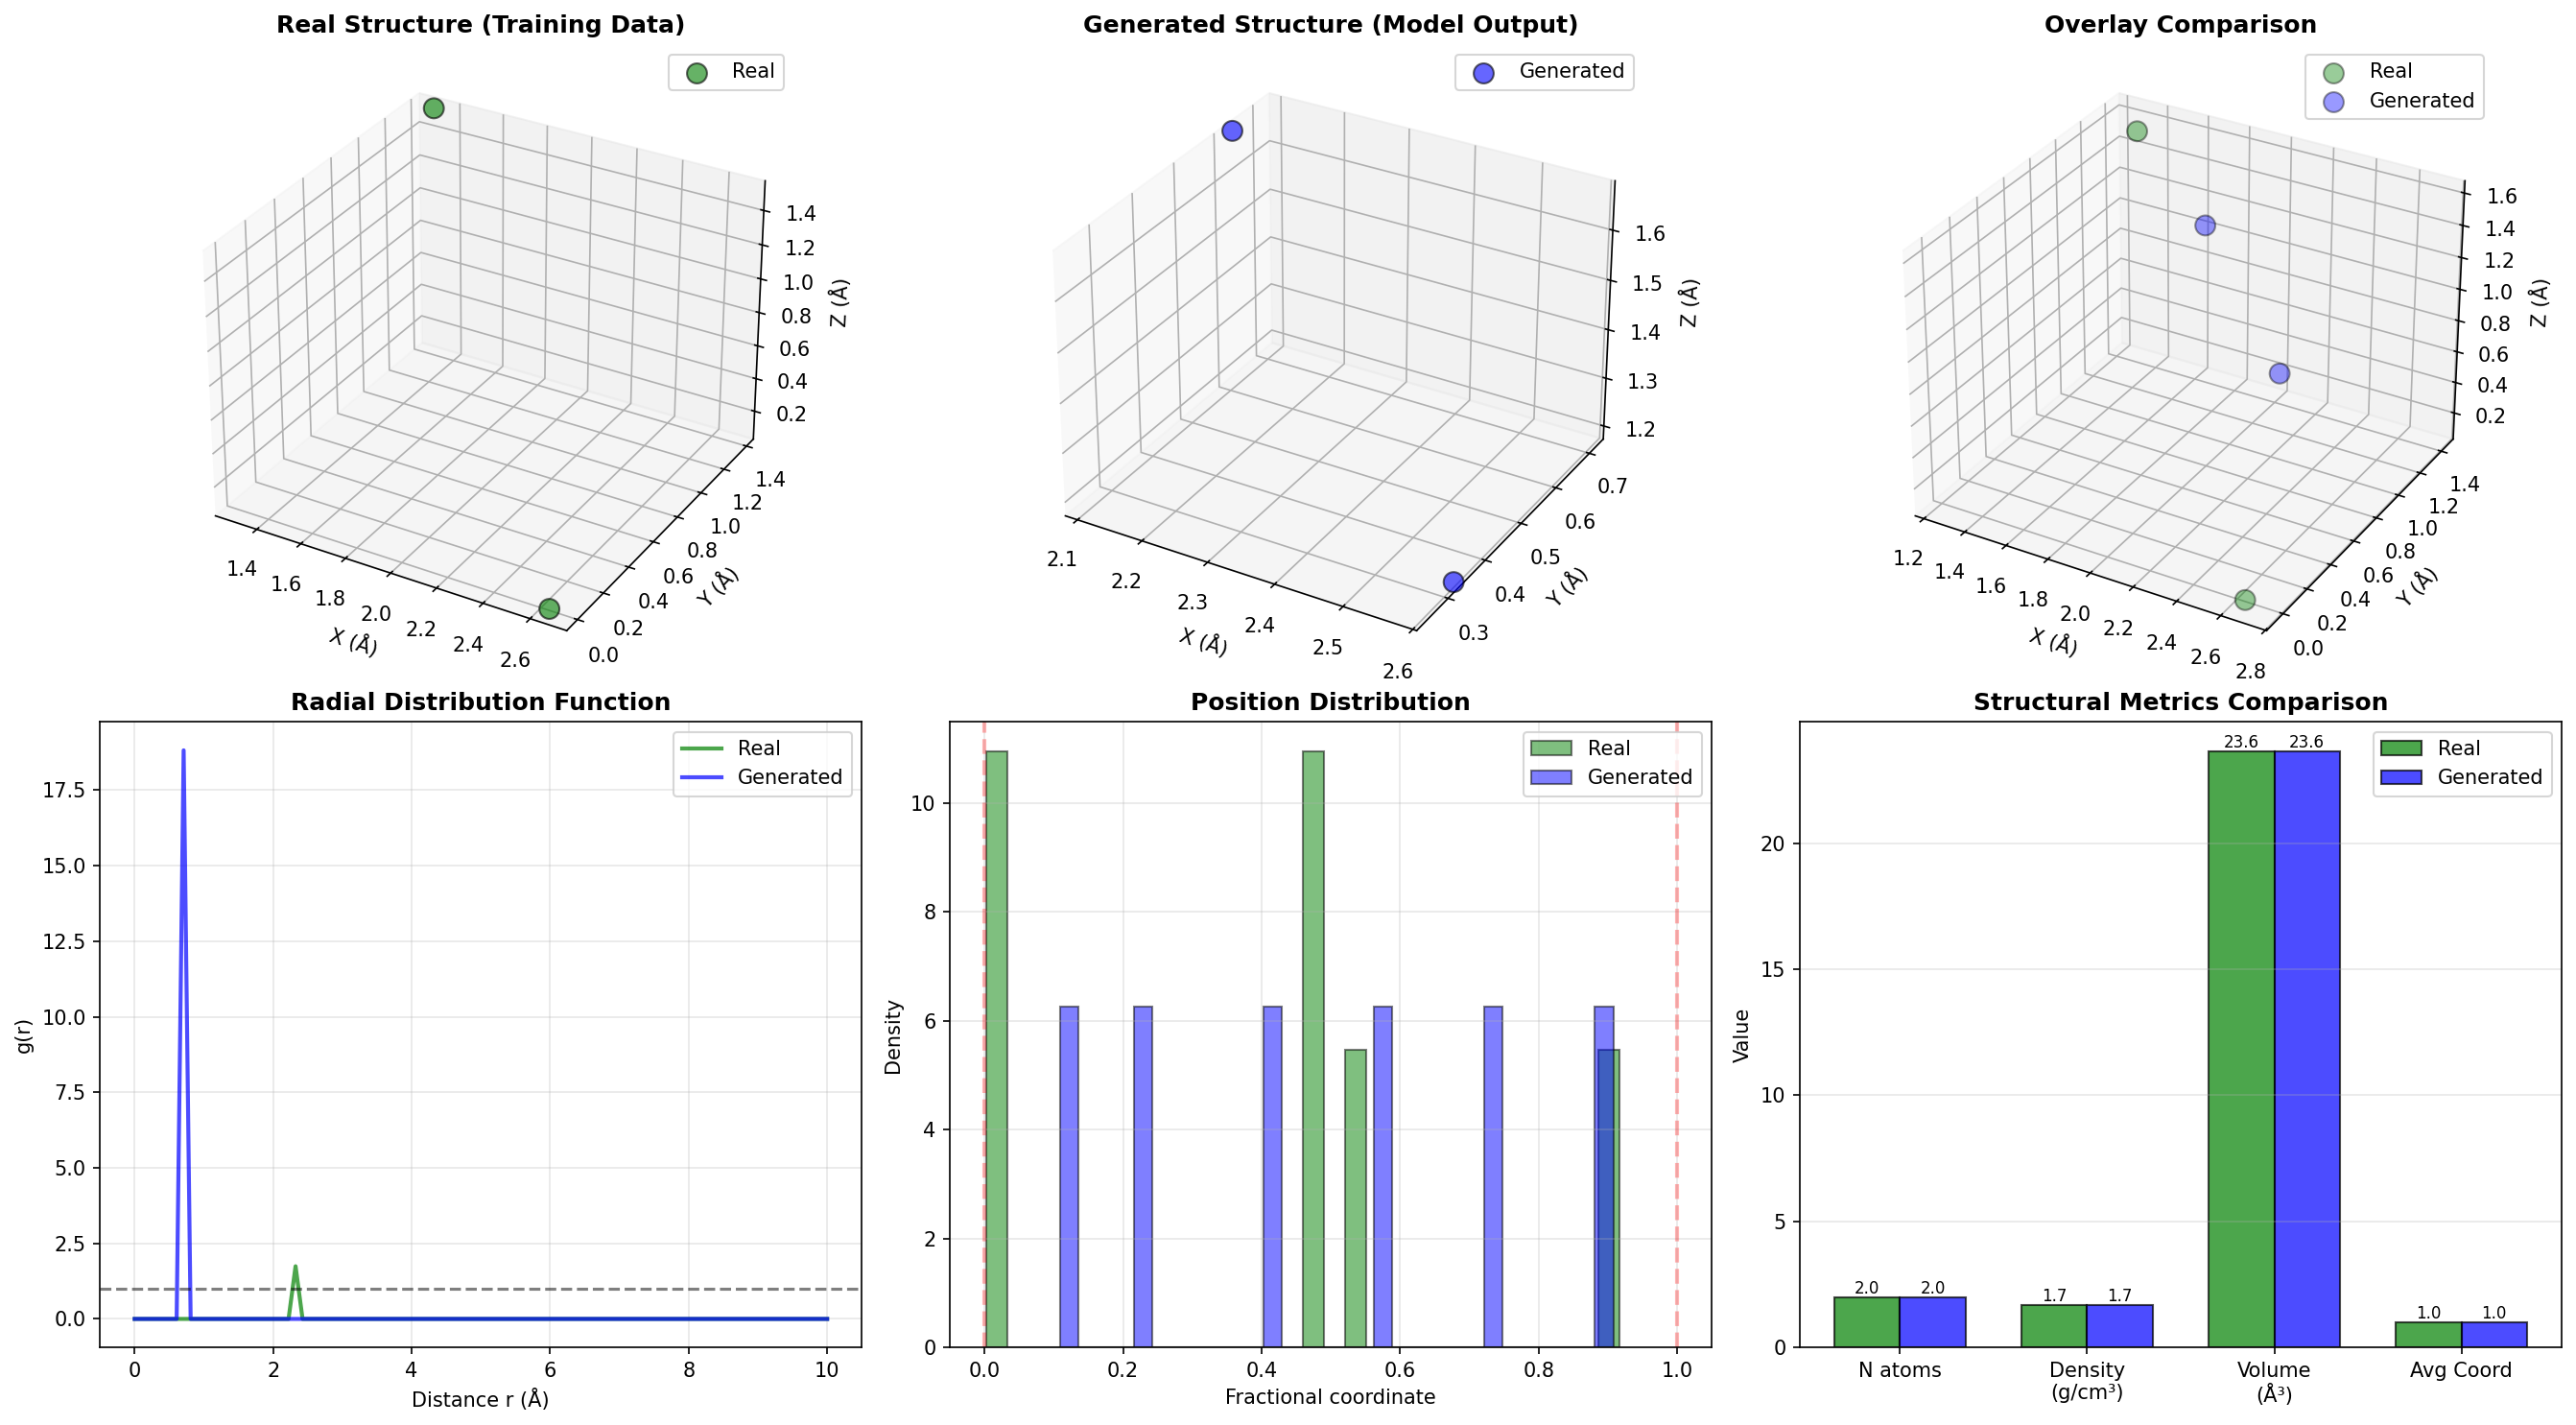


Analysis Complete

Detailed Comparison:

  Real Structure:
    Atoms: 2
    Density: 1.686 g/cm³
    Volume: 23.640 Å³
    Avg Coordination: 1.0

  Generated Structure:
    Atoms: 2
    Density: 1.686 g/cm³
    Volume: 23.640 Å³
    Avg Coordination: 1.0

  Differences:
    Δ Atoms: 0
    Δ Density: 0.000 g/cm³
    Δ Coordination: 0.0


In [20]:
def compute_rdf(positions, lattice, r_max=10.0, dr=0.1):
    """
    Compute radial distribution function.
    
    Args:
        positions: (N, 3) fractional coordinates
        lattice: (3, 3) lattice vectors
        r_max: Maximum radius in Angstroms
        dr: Bin width in Angstroms
        
    Returns:
        r_values: Array of radii
        g_r: Radial distribution function values
    """
    cart_pos = positions @ lattice
    n_atoms = len(cart_pos)
    volume = np.abs(np.linalg.det(lattice))
    rho = n_atoms / volume
    
    # Initialize bins
    n_bins = int(r_max / dr)
    hist = np.zeros(n_bins)
    r_values = np.linspace(0, r_max, n_bins)
    
    # Compute pairwise distances
    for i in range(n_atoms):
        for j in range(i + 1, n_atoms):
            diff = cart_pos[i] - cart_pos[j]
            
            # Apply PBC
            diff_frac = diff @ np.linalg.inv(lattice.T)
            diff_frac = diff_frac - np.round(diff_frac)
            diff = diff_frac @ lattice
            
            dist = np.linalg.norm(diff)
            
            if dist < r_max:
                bin_idx = int(dist / dr)
                if bin_idx < n_bins:
                    hist[bin_idx] += 2  # Count both i->j and j->i
    
    # Normalize
    for i in range(n_bins):
        r = r_values[i]
        if r > 0:
            shell_volume = 4 * np.pi * r**2 * dr
            hist[i] /= (shell_volume * rho * n_atoms)
    
    return r_values, hist

# Compare generated vs real structure
print(f"Comparing generated vs real structures...\n")

# Real structure from dataset
real_pos = sample_batch['positions'][0][sample_batch['mask'][0] > 0.5].numpy()
real_lattice = sample_batch['lattice'][0].numpy()

# Compute RDFs
r_real, g_real = compute_rdf(real_pos, real_lattice)
r_gen, g_gen = compute_rdf(gen_pos, lat)

# Create comparison figure with FIXED 3D subplot initialization
fig = plt.figure(figsize=(18, 10))

# Row 1: 3D structures - CREATE THEM PROPERLY
ax1 = fig.add_subplot(2, 3, 1, projection='3d')
cart_real = real_pos @ real_lattice
ax1.scatter(cart_real[:, 0], cart_real[:, 1], cart_real[:, 2],
           c='green', s=100, alpha=0.6, edgecolors='black', label='Real')
ax1.set_xlabel('X (Å)')
ax1.set_ylabel('Y (Å)')
ax1.set_zlabel('Z (Å)')
ax1.set_title('Real Structure (Training Data)', fontsize=12, fontweight='bold')
ax1.legend()
# Set equal aspect ratio for 3D plot
max_range = np.array([cart_real[:, 0].max()-cart_real[:, 0].min(),
                      cart_real[:, 1].max()-cart_real[:, 1].min(),
                      cart_real[:, 2].max()-cart_real[:, 2].min()]).max() / 2.0
mid_x = (cart_real[:, 0].max()+cart_real[:, 0].min()) * 0.5
mid_y = (cart_real[:, 1].max()+cart_real[:, 1].min()) * 0.5
mid_z = (cart_real[:, 2].max()+cart_real[:, 2].min()) * 0.5
ax1.set_xlim(mid_x - max_range, mid_x + max_range)
ax1.set_ylim(mid_y - max_range, mid_y + max_range)
ax1.set_zlim(mid_z - max_range, mid_z + max_range)

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
cart_gen = gen_pos @ lat
ax2.scatter(cart_gen[:, 0], cart_gen[:, 1], cart_gen[:, 2],
           c='blue', s=100, alpha=0.6, edgecolors='black', label='Generated')
ax2.set_xlabel('X (Å)')
ax2.set_ylabel('Y (Å)')
ax2.set_zlabel('Z (Å)')
ax2.set_title('Generated Structure (Model Output)', fontsize=12, fontweight='bold')
ax2.legend()
# Set equal aspect ratio
max_range = np.array([cart_gen[:, 0].max()-cart_gen[:, 0].min(),
                      cart_gen[:, 1].max()-cart_gen[:, 1].min(),
                      cart_gen[:, 2].max()-cart_gen[:, 2].min()]).max() / 2.0
mid_x = (cart_gen[:, 0].max()+cart_gen[:, 0].min()) * 0.5
mid_y = (cart_gen[:, 1].max()+cart_gen[:, 1].min()) * 0.5
mid_z = (cart_gen[:, 2].max()+cart_gen[:, 2].min()) * 0.5
ax2.set_xlim(mid_x - max_range, mid_x + max_range)
ax2.set_ylim(mid_y - max_range, mid_y + max_range)
ax2.set_zlim(mid_z - max_range, mid_z + max_range)

# Overlay
ax3 = fig.add_subplot(2, 3, 3, projection='3d')
ax3.scatter(cart_real[:, 0], cart_real[:, 1], cart_real[:, 2],
           c='green', s=100, alpha=0.4, edgecolors='black', label='Real')
ax3.scatter(cart_gen[:, 0], cart_gen[:, 1], cart_gen[:, 2],
           c='blue', s=100, alpha=0.4, edgecolors='black', label='Generated')
ax3.set_xlabel('X (Å)')
ax3.set_ylabel('Y (Å)')
ax3.set_zlabel('Z (Å)')
ax3.set_title('Overlay Comparison', fontsize=12, fontweight='bold')
ax3.legend()
# Set equal aspect ratio based on combined data
all_cart = np.vstack([cart_real, cart_gen])
max_range = np.array([all_cart[:, 0].max()-all_cart[:, 0].min(),
                      all_cart[:, 1].max()-all_cart[:, 1].min(),
                      all_cart[:, 2].max()-all_cart[:, 2].min()]).max() / 2.0
mid_x = (all_cart[:, 0].max()+all_cart[:, 0].min()) * 0.5
mid_y = (all_cart[:, 1].max()+all_cart[:, 1].min()) * 0.5
mid_z = (all_cart[:, 2].max()+all_cart[:, 2].min()) * 0.5
ax3.set_xlim(mid_x - max_range, mid_x + max_range)
ax3.set_ylim(mid_y - max_range, mid_y + max_range)
ax3.set_zlim(mid_z - max_range, mid_z + max_range)

# Row 2: RDF and statistics
ax4 = fig.add_subplot(2, 3, 4)
ax4.plot(r_real, g_real, 'g-', linewidth=2, label='Real', alpha=0.7)
ax4.plot(r_gen, g_gen, 'b-', linewidth=2, label='Generated', alpha=0.7)
ax4.set_xlabel('Distance r (Å)')
ax4.set_ylabel('g(r)')
ax4.set_title('Radial Distribution Function', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Ideal gas')

# Position distribution
ax5 = fig.add_subplot(2, 3, 5)
ax5.hist(real_pos.flatten(), bins=30, alpha=0.5, color='green', 
         label='Real', edgecolor='black', density=True)
ax5.hist(gen_pos.flatten(), bins=30, alpha=0.5, color='blue',
         label='Generated', edgecolor='black', density=True)
ax5.set_xlabel('Fractional coordinate')
ax5.set_ylabel('Density')
ax5.set_title('Position Distribution', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.axvline(x=0, color='red', linestyle='--', alpha=0.3, linewidth=2)
ax5.axvline(x=1, color='red', linestyle='--', alpha=0.3, linewidth=2)

# Statistics comparison
ax6 = fig.add_subplot(2, 3, 6)
metrics = ['N atoms', 'Density\n(g/cm³)', 'Volume\n(Å³)', 'Avg Coord']

# Calculate metrics
real_volume = np.abs(np.linalg.det(real_lattice))
real_density = (len(real_pos) * 12 * 1.66054e-27) / (real_volume * 1e-30) / 1000

# Coordination for real
cart_real_full = real_pos @ real_lattice
real_coord = []
for i in range(len(cart_real_full)):
    count = 0
    for j in range(len(cart_real_full)):
        if i != j:
            diff = cart_real_full[i] - cart_real_full[j]
            diff_frac = diff @ np.linalg.inv(real_lattice.T)
            diff_frac = diff_frac - np.round(diff_frac)
            diff = diff_frac @ real_lattice
            if np.linalg.norm(diff) < 3.0:
                count += 1
    real_coord.append(count)

real_values = [len(real_pos), real_density, real_volume, np.mean(real_coord)]
gen_values = [len(gen_pos), density, volume, np.mean(coordination_numbers)]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax6.bar(x - width/2, real_values, width, label='Real', color='green', alpha=0.7, edgecolor='black')
bars2 = ax6.bar(x + width/2, gen_values, width, label='Generated', color='blue', alpha=0.7, edgecolor='black')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=8)

ax6.set_xticks(x)
ax6.set_xticklabels(metrics)
ax6.set_ylabel('Value')
ax6.set_title('Structural Metrics Comparison', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('outputs_2/structure_comparison.png', dpi=150, bbox_inches='tight')
print(f"\n✓ Structure comparison saved")
plt.show()

print(f"\n{'='*60}")
print(f"Analysis Complete")
print(f"{'='*60}")

# Print detailed comparison
print(f"\nDetailed Comparison:")
print(f"\n  Real Structure:")
print(f"    Atoms: {len(real_pos)}")
print(f"    Density: {real_density:.3f} g/cm³")
print(f"    Volume: {real_volume:.3f} Å³")
print(f"    Avg Coordination: {np.mean(real_coord):.1f}")
print(f"\n  Generated Structure:")
print(f"    Atoms: {len(gen_pos)}")
print(f"    Density: {density:.3f} g/cm³")
print(f"    Volume: {volume:.3f} Å³")
print(f"    Avg Coordination: {np.mean(coordination_numbers):.1f}")
print(f"\n  Differences:")
print(f"    Δ Atoms: {len(gen_pos) - len(real_pos)}")
print(f"    Δ Density: {density - real_density:.3f} g/cm³")
print(f"    Δ Coordination: {np.mean(coordination_numbers) - np.mean(real_coord):.1f}")

## Cell 13: Summary and Research Insights

### Key Findings from This Walkthrough

1. **Diffusion Models for Crystals**:
   - Successfully adapted DDPM to 3D periodic structures
   - Forward process: Controlled noise addition preserving periodicity
   - Reverse process: Neural network-guided denoising

2. **Physics Constraints**:
   - Minimum distance enforcement prevents atomic overlap
   - Periodic boundary conditions maintained throughout
   - Post-generation correction improves physical validity

3. **Neural Network Architecture**:
   - Sinusoidal time embeddings enable timestep conditioning
   - Residual connections improve gradient flow
   - Masking handles variable atom counts

4. **Training Dynamics**:
   - Loss decreases steadily with epochs
   - Gradient clipping prevents instability
   - Small datasets can work with proper regularization

### Research Extensions

1. **Conditional Generation**:
   - Add chemical composition as input
   - Control lattice parameters
   - Target specific properties (bandgap, conductivity)

2. **Improved Physics**:
   - Electrostatic interactions (Ewald summation)
   - Full space group symmetry
   - Force field-guided correction

3. **Architecture Improvements**:
   - Graph neural networks for atomic interactions
   - Equivariant networks for rotational invariance
   - Attention mechanisms for long-range correlations

4. **Large-Scale Training**:
   - Materials Project database (~150K structures)
   - OQMD database (~800K structures)
   - Transfer learning from related systems

### Computational Complexity Summary

| Operation | Time Complexity | Space Complexity |
|-----------|----------------|------------------|
| Forward diffusion | $O(N)$ | $O(N)$ |
| Neural network forward | $O(N \times d^2)$ | $O(N \times d)$ |
| Reverse diffusion (sampling) | $O(T \times N \times d^2)$ | $O(N \times d)$ |
| Physics validation | $O(N^2)$ | $O(N^2)$ |
| Training epoch | $O(B \times T \times N \times d^2)$ | $O(B \times N \times d)$ |

Where:
- $N$: Number of atoms
- $d$: Hidden dimension
- $T$: Number of diffusion timesteps
- $B$: Batch size

### References

1. **DDPM**: Ho et al. "Denoising Diffusion Probabilistic Models" (2020)
2. **Improved DDPM**: Nichol & Dhariwal "Improved Denoising Diffusion Probabilistic Models" (2021)
3. **Transformer**: Vaswani et al. "Attention is All You Need" (2017)
4. **Crystal Diffusion**: Jiao et al. "Crystal Diffusion Variational Autoencoder" (2023)
5. **Physics-Constrained ML**: Battaglia et al. "Interaction Networks" (2016)

In [ ]:
# Final summary statistics
print(f"\n{'='*70}")
print(f"                 CRYSTAL DIFFUSION MODEL - SUMMARY")
print(f"{'='*70}\n")

print(f"Training Configuration:")
print(f"  Dataset size: {len(dataset)} structures")
print(f"  Epochs trained: {config['epochs']}")
print(f"  Batch size: {config['batch_size']}")
print(f"  Total iterations: {len(losses)}")
print(f"  Device: {device}")

print(f"\nModel Architecture:")
total_params = sum(p.numel() for p in model.model.parameters())
print(f"  Total parameters: {total_params:,}")
print(f"  Hidden dimension: {model.model.hidden_dim}")
print(f"  Number of layers: {model.model.num_layers}")
print(f"  Timesteps: {model.timesteps}")

print(f"\nTraining Results:")
print(f"  Initial loss: {epoch_losses[0]:.6f}")
print(f"  Final loss: {epoch_losses[-1]:.6f}")
print(f"  Best loss: {min(epoch_losses):.6f}")
print(f"  Improvement: {(epoch_losses[0] - epoch_losses[-1]) / epoch_losses[0] * 100:.1f}%")

print(f"\nGeneration Results:")
print(f"  Physics validation: {'✓ PASSED' if valid else '✗ FAILED'}")
print(f"  Minimum distance: {min_dist:.3f} Å (threshold: {model.validator.min_distance} Å)")
print(f"  Generated atoms: {len(gen_pos)}")
print(f"  Density: {density:.3f} g/cm³")
print(f"  Average coordination: {np.mean(coordination_numbers):.1f}")

print(f"\nComputational Performance:")
print(f"  Training time complexity: O(E × B × T × N × d²)")
print(f"  Sampling time complexity: O(T × N × d²)")
print(f"  Where: E={config['epochs']}, B={config['batch_size']}, T={model.timesteps}, N≤{max_atoms}, d={model.model.hidden_dim}")

print(f"\n{'='*70}")
print(f"         All outputs saved to outputs_@")
print(f"{'='*70}")

print(f"\nGenerated Files:")
print(f"  1. diffusion_schedule_analysis.png - Variance schedule visualization")
print(f"  2. forward_diffusion_process.png - Noise addition process")
print(f"  3. training_curve.png - Loss curves")
print(f"  4. reverse_diffusion_process.png - Denoising steps")
print(f"  5. structure_comparison.png - Real vs Generated comparison")

print(f"\n✓ Analysis complete! Ready for research applications.\n")